## Predictive Maintenance Example: Machine Learning Modeling Improvements
#### Supplement to 'Operationalizing Predictive Maintenance on a Distributed Network of Equipment'
###### Melissa Perry
###### UWEX Data Science Masters Program Capstone
###### December 12, 2021

In [1]:
# computational imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.formula.api as smf

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# for reading files from urls
import urllib.request
# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# # import notebook styling for tables and width etc.
# response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
# HTML(response.read().decode("utf-8"));

# import warnings
import warnings

In [2]:
# import data from previous notebook.
X_train = pd.read_csv('x_train.csv').iloc[: , 2:]
y_train = pd.read_csv('y_train.csv')['RUL']
X_test = pd.read_csv('x_test.csv').iloc[: , 2:]
y_test = pd.read_csv('y_test.csv')['RUL']

In [3]:
#bring in useful functions from previous notebook. 
def my_regression_results(model):
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))
   
    y_pred = model.predict(X_test)
    # import matplotlib.pyplot as plt
    plt.figure(figsize=(9,6))
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    # from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))

#write a function to display results in a short list with no visuals.
def my_short_regression_results(model):
    score_test = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    return(score_test, mse, rmse)

#### Proposed Methods to Improve Model Performance
1. Scale the data to symmetry for tree based models.
2. Add lagged aggregates to capture degradation over time for all models. 
3. Use hyperparameter tuning for tree-based models. 

##### Proposal 1: Scaling the Data for the tree-based regression models.

In [4]:
#implement standard scaling routine for train and test sets. 
scaler = StandardScaler()
scaler = StandardScaler().fit(X_train.values)
features = scaler.transform(X_train.values)
X_train_scaled = pd.DataFrame(features, columns = X_train.columns)
X_train_scaled

,T30,T50,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,-0.134255,-0.925936,1.121141,-0.266467,0.334262,-0.269071,-0.603816,-0.781710,1.348493,1.194427,-0.516338,-1.058890
1,0.211528,-0.643726,0.431930,-0.191583,1.174899,-0.642845,-0.275852,-0.781710,1.016528,1.236922,-0.798093,-0.363646
2,-0.413166,-0.525953,1.008155,-1.015303,1.364721,-0.551629,-0.649144,-2.073094,0.739891,0.503423,-0.234584,-0.919841
3,-1.261314,-0.784831,1.222827,-1.539489,1.961302,-0.520176,-1.971665,-0.781710,0.352598,0.777792,0.188048,-0.224597
4,-1.251528,-0.301518,0.714393,-0.977861,1.052871,-0.521748,-0.339845,-0.136018,0.463253,1.059552,-0.516338,-0.780793
...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.216258,2.188375,-2.189329,1.980044,-2.607969,-0.322542,1.425294,2.446751,-1.805173,-2.921113,1.315066,2.278282
20627,2.279706,2.738351,-2.833345,1.867718,-2.350355,-0.380207,1.913240,1.155367,-2.856395,-1.203764,1.878576,1.722087
20628,1.946971,2.138377,-2.742957,2.054927,-1.902919,-0.141684,3.265092,3.092444,-2.081810,-3.292481,2.019453,2.000184
20629,2.403666,1.955051,-3.036719,3.178182,-2.363913,-0.233948,2.579834,1.155367,-2.911722,-2.085072,2.160330,1.861136


In [5]:
#repeat for test
scaler = StandardScaler().fit(X_test.values)
features = scaler.transform(X_test.values)
X_test_scaled = pd.DataFrame(features, columns = X_test.columns)
X_test_scaled 

,T30,T50,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,-1.603619,-1.355943,1.451228,-1.427840,0.739155,-0.657866,-1.537896,-0.356332,0.291274,0.994198,-0.607375,-0.842309
1,-0.791580,0.032832,0.423689,0.292920,0.667113,-0.831042,-0.071375,-1.726838,0.291274,0.021750,-0.296697,-0.401310
2,-0.313732,0.971886,-0.638102,1.114192,-0.644059,-0.585035,-1.248251,1.014175,1.064567,0.148772,0.635336,0.333690
3,0.409090,-0.427375,-0.581016,0.214704,0.868832,-0.467426,0.321934,1.014175,-1.190872,-0.016773,0.169319,-0.107310
4,-0.285000,1.026645,0.161095,-0.528352,-0.399115,-0.893623,-0.507368,0.328921,-0.095373,1.582456,-0.296697,0.480690
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.142855,-1.468956,0.960293,-1.779813,1.473988,0.320231,-1.275691,-1.726838,1.257891,2.091585,-1.384069,-1.577309
96,-1.340501,0.043318,1.028795,-0.841217,0.436577,0.710822,-0.086619,1.014175,-0.997549,0.370540,-0.918053,-0.842309
97,1.162154,0.573429,0.332352,0.253812,0.364535,0.220425,-0.894578,0.328921,-0.030932,1.052503,0.169319,-0.401310
98,-1.027480,-1.464295,1.827992,-1.310515,0.782381,0.435682,-1.601923,-1.726838,1.193450,1.038968,-1.694747,-1.430309


Now attempt to redo tree based models and assess whether there is model improvement. 

Model r-squared score from test data: -0.0268
Mean squared error on test data: 1773.18
Root mean squared error on test data: 42.11


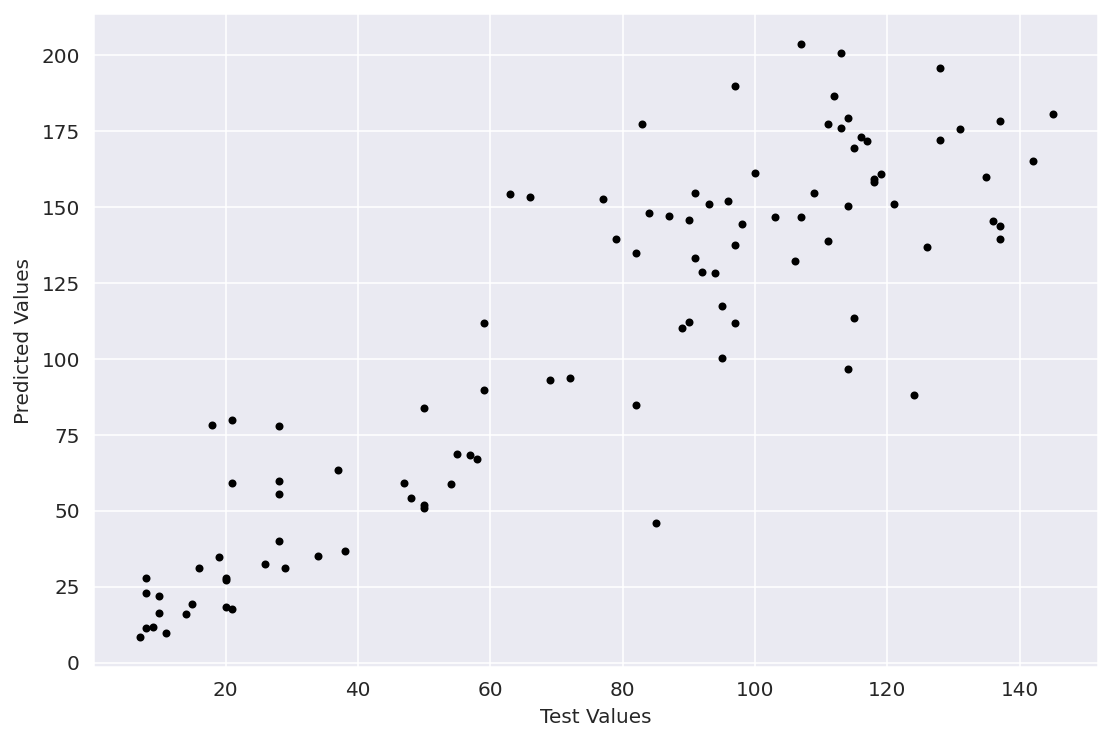

In [6]:
#random forest regression model
X_test = X_test_scaled

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train_scaled,y_train)

my_regression_results(rf_model)

In [7]:
round(rf_model.score(X_train,y_train),2)

-1.95

Model r-squared score from test data: 0.0586
Mean squared error on test data: 1625.60
Root mean squared error on test data: 40.32


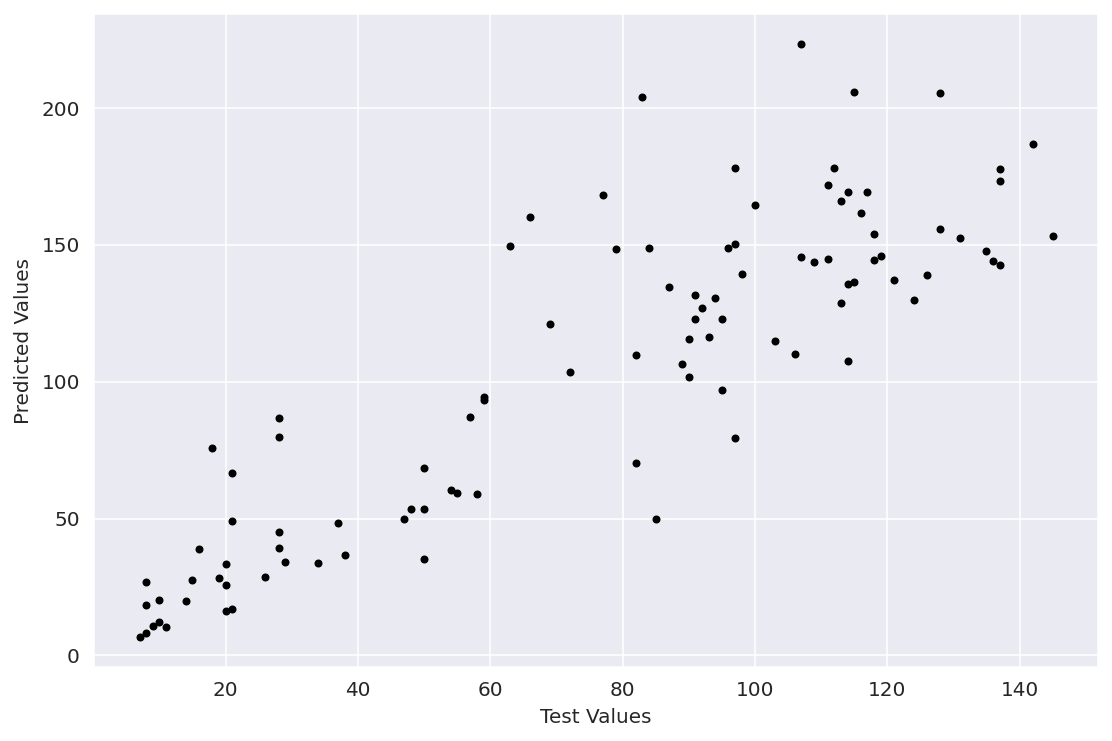

In [8]:
#xgboost regression model
xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgbr_model.fit(X_train_scaled,y_train)

my_regression_results(xgbr_model)

In [9]:
round(xgbr_model.score(X_train,y_train),2)

-3.26

This treatment was ineffective in improving performance of the tree-based models. We are better off leaving the data unscaled. The random forest model shows a negative r-squared, which proves worse than having no model at all. The xgboost model performs worse than initially on the test set. We will reverse course and pull in the data as we had before to attempt the next proposal. 

In [10]:
# import data from previous notebook.
X_train = pd.read_csv('x_train.csv').iloc[: , 2:]
X_test = pd.read_csv('x_test.csv').iloc[: , 2:]

##### Proposal 2: Add lagged aggregates to capture degradation over time for all models. 
We will adapt learnings from existing code bases to help create efficient functions that can be used to create both rolling aggregates and lags of them in our dataset. We will experiment with both short and long term lags to help train the model to detect degradation of sensors over time. 

Sources:
* https://towardsdatascience.com/time-series-analysis-for-predictive-maintenance-of-turbofan-engines-1b3864991da4
* https://www.oreilly.com/library/view/predictive-maintenance-meets/9781491972540/

In [11]:
#adapt function from Peter Koen's time series work to add lagged variables. 
def add_lagged_variables(df_input, lags, columns):
    df = df_input.copy()
    for i in range(lags):
        lagged_columns = [col + '_lag_{}'.format(i+1) for col in columns]
        df[lagged_columns] = df.groupby('unit_number')[columns].shift(i+1)
    df.dropna(inplace=True)
    return df

In [12]:
#write a function to generate rolling aggregate value within a particular window over a list of grouped dataframes.
def add_rolling_agg_variables(key, value_df, window):
    df = value_df.assign(group = key) # this pandas method returns a copy of the df, with group columns assigned the key value
    #for each col in the df, generate the aggregate, then rename the column with the aggregate name
    df = df.sort_values(by=["time_in_cycles"], ascending=True).set_index(["time_in_cycles"])
    for c in df.columns:
        df[str(c+'_roll_median'+str(window))] = df[c].rolling(3).median()
    df.dropna(inplace=True)
    return (df)

In [13]:
# define filepath to read data
dir_path = './data/'

# define column names for easy indexing
index_names = ['unit_number', 'time_in_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [14]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_in_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_in_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_number,time_in_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [15]:
#take the difference of variables from their demanded levels. 
train['Nf_diff']=train['Nf']-train['Nf_dmd']
train['NRf_diff'] = train['NRf']-train['PCNfR_dmd']
test['Nf_diff']=test['Nf']-test['Nf_dmd']
test['NRf_diff'] = test['NRf']-test['PCNfR_dmd']

# drop unwanted columns and split target variable from training set
drop_sensors = ['T2', 'P2','epr','farB','Nf_dmd','PCNfR_dmd','Nc','Nf','NRf'] # observe rationale in Predictive Maintenance EDA and Feature Engineering file, where these variables produce no additional data.  
drop_labels = setting_names+drop_sensors # alter this version of the work to keep RUL and Unit number, as we need these to add lags and aggregates. 

X_train = train.drop(drop_labels, axis=1)
#y_train = X_train.pop('RUL') #do this later following transformations.
remaining_sensors = X_train.columns.difference(index_names+['RUL'])

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
#X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)
X_test = test.drop(drop_labels, axis=1)

print(X_train.columns)  # check remaining columns

Index(['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P15', 'P30',
       'Ps30', 'phi', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'RUL', 'Nf_diff',
       'NRf_diff'],
      dtype='object')


In [16]:
#prepare X_train. 

#apply rolling aggregates to train. 
grouped_df=X_train.groupby(['unit_number'])
dflist = [add_rolling_agg_variables(g, grouped_df.get_group(g),3) for g in grouped_df.groups.keys()]
X_train = pd.concat(dflist, axis=0).reset_index()

#apply lags to the aggregates in the short and long term. 
agg_columns=[col for col in X_train.columns if 'median' in col]
X_train = add_lagged_variables(X_train,10,agg_columns)
y_train = X_train.pop('RUL')


#Repeat for X_test. 

#apply rolling aggregates to test. 
grouped_df=X_test.groupby(['unit_number'])
dflist = [add_rolling_agg_variables(g, grouped_df.get_group(g),3) for g in grouped_df.groups.keys()]
X_test = pd.concat(dflist, axis=0).reset_index()

#apply lags to the aggregates in the short and long term. 
agg_columns=[col for col in X_test.columns if 'median' in col]
X_test= add_lagged_variables(X_test,10,agg_columns)

In [17]:
X_train

,time_in_cycles,unit_number,T24,T30,T50,P15,P30,Ps30,phi,NRc,...,phi_roll_median3_lag_10,NRc_roll_median3_lag_10,BPR_roll_median3_lag_10,htBleed_roll_median3_lag_10,W31_roll_median3_lag_10,W32_roll_median3_lag_10,RUL_roll_median3_lag_10,Nf_diff_roll_median3_lag_10,NRf_diff_roll_median3_lag_10,group_roll_median3_lag_10
10,13,1,643.07,1582.19,1400.83,21.61,553.44,47.38,521.85,8128.10,...,522.28,8133.23,8.4195,392.0,39.00,23.4190,190.0,0.06,2288.03,1.0
11,14,1,642.35,1592.95,1399.16,21.61,554.48,47.44,521.67,8134.43,...,522.42,8133.23,8.4178,392.0,38.95,23.3739,189.0,0.08,2288.07,1.0
12,15,1,642.43,1583.82,1402.13,21.61,553.64,47.30,522.50,8127.56,...,522.42,8133.80,8.4178,392.0,38.90,23.3739,188.0,0.08,2288.04,1.0
13,16,1,642.13,1587.98,1404.50,21.61,553.94,47.24,521.49,8136.11,...,522.19,8133.80,8.4108,392.0,38.90,23.3739,187.0,0.06,2288.04,1.0
14,17,1,642.58,1584.96,1399.95,21.61,553.80,47.12,521.89,8137.27,...,522.19,8132.85,8.4108,392.0,38.98,23.3774,186.0,0.02,2288.03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,196,100,643.49,1597.98,1428.63,21.61,551.43,48.07,519.49,8137.60,...,520.66,8142.28,8.4804,395.0,38.51,23.1229,15.0,0.20,2288.20,100.0
20427,197,100,643.54,1604.50,1433.58,21.61,550.86,48.04,519.68,8136.50,...,520.66,8140.49,8.4804,395.0,38.60,23.2127,14.0,0.20,2288.22,100.0
20428,198,100,643.42,1602.46,1428.18,21.61,550.94,48.09,520.01,8141.05,...,520.15,8139.94,8.4814,395.0,38.51,23.1173,13.0,0.22,2288.22,100.0
20429,199,100,643.23,1605.26,1426.53,21.61,550.68,48.39,519.67,8139.29,...,519.98,8139.94,8.4870,396.0,38.65,23.0591,12.0,0.22,2288.22,100.0


In [18]:
# #implement standard scaling routine for train and test sets. 
# scaler = StandardScaler()
# scaler = StandardScaler().fit(X_train.values)
# features = scaler.transform(X_train.values)
# X_train_scaled = pd.DataFrame(features, columns = X_train.columns)
# X_train_scaled

# X_train = X_train_scaled
# X_train.head()

In [19]:
# #repeat for test
# scaler = StandardScaler().fit(X_test.values)
# features = scaler.transform(X_test.values)
# X_test_scaled = pd.DataFrame(features, columns = X_test.columns)
# X_test = X_test_scaled 
# X_test.head()

In [20]:
#clean out unhelpful columns from train and test sets. 

#start with train
group_columns=[col for col in X_train.columns if 'group' in col]
rul_columns=[col for col in X_train.columns if 'RUL' in col]
unit_number_columns=[col for col in X_train.columns if 'unit_number' in col]

drop_labels = group_columns+rul_columns+unit_number_columns+index_names
X_train = X_train.drop(drop_labels,axis=1)

#repeat for test
X_test = X_test.groupby('unit_number').last().reset_index()
group_columns=[col for col in X_test.columns if 'group' in col]
unit_number_columns=[col for col in X_test.columns if 'unit_number' in col]
drop_labels = group_columns+unit_number_columns+index_names
X_test = X_test.drop(drop_labels,axis=1)

In [21]:
y_train

10       179
11       178
12       177
13       176
14       175
        ... 
20426      4
20427      3
20428      2
20429      1
20430      0
Name: RUL, Length: 19431, dtype: int64

In [22]:
list(X_train.columns)

['T24',
 'T30',
 'T50',
 'P15',
 'P30',
 'Ps30',
 'phi',
 'NRc',
 'BPR',
 'htBleed',
 'W31',
 'W32',
 'Nf_diff',
 'NRf_diff',
 'T24_roll_median3',
 'T30_roll_median3',
 'T50_roll_median3',
 'P15_roll_median3',
 'P30_roll_median3',
 'Ps30_roll_median3',
 'phi_roll_median3',
 'NRc_roll_median3',
 'BPR_roll_median3',
 'htBleed_roll_median3',
 'W31_roll_median3',
 'W32_roll_median3',
 'Nf_diff_roll_median3',
 'NRf_diff_roll_median3',
 'T24_roll_median3_lag_1',
 'T30_roll_median3_lag_1',
 'T50_roll_median3_lag_1',
 'P15_roll_median3_lag_1',
 'P30_roll_median3_lag_1',
 'Ps30_roll_median3_lag_1',
 'phi_roll_median3_lag_1',
 'NRc_roll_median3_lag_1',
 'BPR_roll_median3_lag_1',
 'htBleed_roll_median3_lag_1',
 'W31_roll_median3_lag_1',
 'W32_roll_median3_lag_1',
 'Nf_diff_roll_median3_lag_1',
 'NRf_diff_roll_median3_lag_1',
 'T24_roll_median3_lag_2',
 'T30_roll_median3_lag_2',
 'T50_roll_median3_lag_2',
 'P15_roll_median3_lag_2',
 'P30_roll_median3_lag_2',
 'Ps30_roll_median3_lag_2',
 'phi_roll_

In [23]:
list(X_test.columns)

['T24',
 'T30',
 'T50',
 'P15',
 'P30',
 'Ps30',
 'phi',
 'NRc',
 'BPR',
 'htBleed',
 'W31',
 'W32',
 'Nf_diff',
 'NRf_diff',
 'T24_roll_median3',
 'T30_roll_median3',
 'T50_roll_median3',
 'P15_roll_median3',
 'P30_roll_median3',
 'Ps30_roll_median3',
 'phi_roll_median3',
 'NRc_roll_median3',
 'BPR_roll_median3',
 'htBleed_roll_median3',
 'W31_roll_median3',
 'W32_roll_median3',
 'Nf_diff_roll_median3',
 'NRf_diff_roll_median3',
 'T24_roll_median3_lag_1',
 'T30_roll_median3_lag_1',
 'T50_roll_median3_lag_1',
 'P15_roll_median3_lag_1',
 'P30_roll_median3_lag_1',
 'Ps30_roll_median3_lag_1',
 'phi_roll_median3_lag_1',
 'NRc_roll_median3_lag_1',
 'BPR_roll_median3_lag_1',
 'htBleed_roll_median3_lag_1',
 'W31_roll_median3_lag_1',
 'W32_roll_median3_lag_1',
 'Nf_diff_roll_median3_lag_1',
 'NRf_diff_roll_median3_lag_1',
 'T24_roll_median3_lag_2',
 'T30_roll_median3_lag_2',
 'T50_roll_median3_lag_2',
 'P15_roll_median3_lag_2',
 'P30_roll_median3_lag_2',
 'Ps30_roll_median3_lag_2',
 'phi_roll_

For this attempt we arbitrarily chose 10 lags of 3-cycle rolling medians for each of the sensor values. We anticipate this kind of transformation will add severe multicollinearity, and as a result we will scale the dataset as we did before before attempting our modeling efforts. 

In [24]:
X_test

,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,...,P30_roll_median3_lag_10,Ps30_roll_median3_lag_10,phi_roll_median3_lag_10,NRc_roll_median3_lag_10,BPR_roll_median3_lag_10,htBleed_roll_median3_lag_10,W31_roll_median3_lag_10,W32_roll_median3_lag_10,Nf_diff_roll_median3_lag_10,NRf_diff_roll_median3_lag_10
0,642.58,1581.22,1398.91,21.61,554.42,47.23,521.79,8130.11,8.4024,393,...,554.31,47.36,522.06,8128.59,8.4099,392.0,39.00,23.3809,0.05,2288.05
1,642.55,1586.59,1410.83,21.61,553.52,47.67,521.74,8126.90,8.4505,391,...,553.49,47.50,521.74,8128.53,8.4363,393.0,38.81,23.3072,0.10,2288.13
2,642.88,1589.75,1418.89,21.61,552.59,47.88,520.83,8131.46,8.4119,395,...,553.41,47.68,521.06,8131.67,8.4621,393.0,38.85,23.2683,0.14,2288.17
3,642.78,1594.53,1406.88,21.61,552.64,47.65,521.88,8133.64,8.4634,395,...,553.18,47.58,521.59,8128.48,8.4347,393.0,38.79,23.2455,0.10,2288.14
4,642.27,1589.94,1419.36,21.61,553.29,47.46,521.00,8125.74,8.4362,394,...,553.08,47.66,521.20,8131.07,8.4380,393.0,38.78,23.2643,0.08,2288.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,642.30,1590.88,1397.94,21.61,553.99,47.14,522.30,8148.24,8.4110,391,...,554.37,47.29,522.02,8146.24,8.4014,392.0,39.02,23.3896,0.03,2288.04
96,642.59,1582.96,1410.92,21.61,554.05,47.38,521.58,8155.48,8.4500,395,...,553.82,47.32,522.02,8153.94,8.4360,393.0,38.96,23.3880,0.03,2288.03
97,642.68,1599.51,1415.47,21.61,553.44,47.66,521.53,8146.39,8.4235,394,...,553.64,47.54,521.03,8143.10,8.4594,393.0,38.84,23.2450,0.12,2288.11
98,642.00,1585.03,1397.98,21.61,554.75,47.26,521.82,8150.38,8.4003,391,...,554.76,47.30,522.44,8148.36,8.3969,390.0,39.02,23.3769,0.01,2288.01


Model r-squared score from test data: 0.5045
Mean squared error on test data: 855.63
Root mean squared error on test data: 29.25


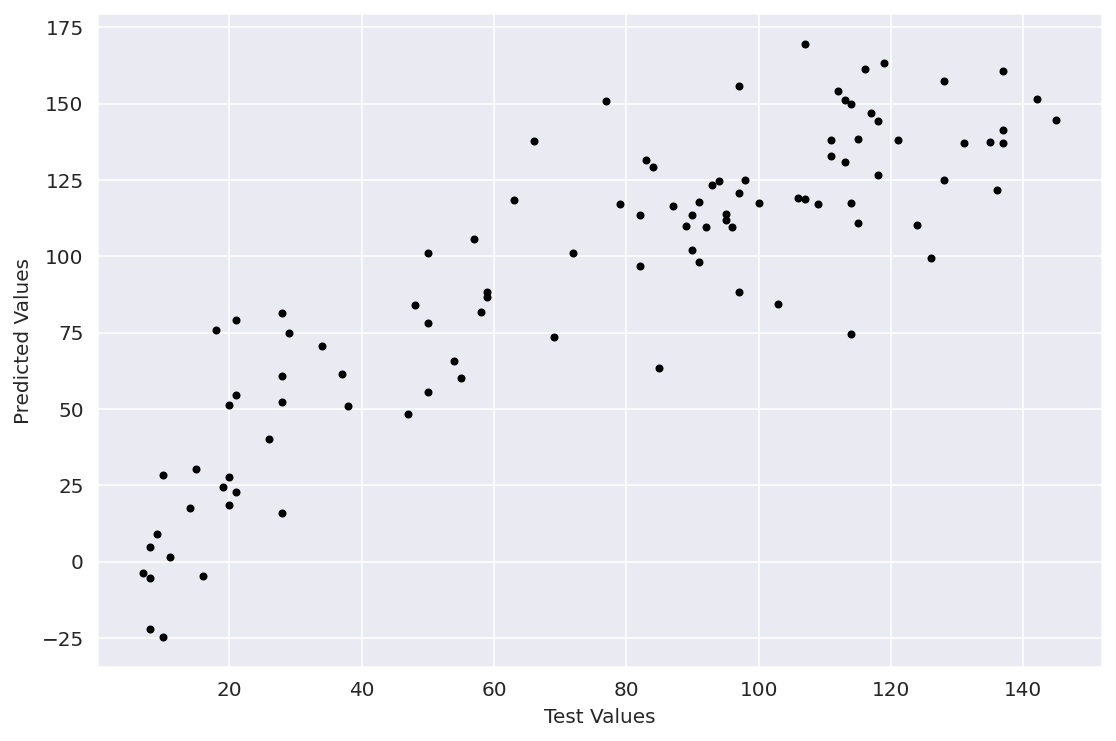

In [25]:
# from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

my_regression_results(model_lr)

In [26]:
round(cross_val_score(model_lr,X_train,y_train,scoring='r2', cv=5).mean(),2)

0.6

Model r-squared score from test data: 0.4596
Mean squared error on test data: 933.27
Root mean squared error on test data: 30.55


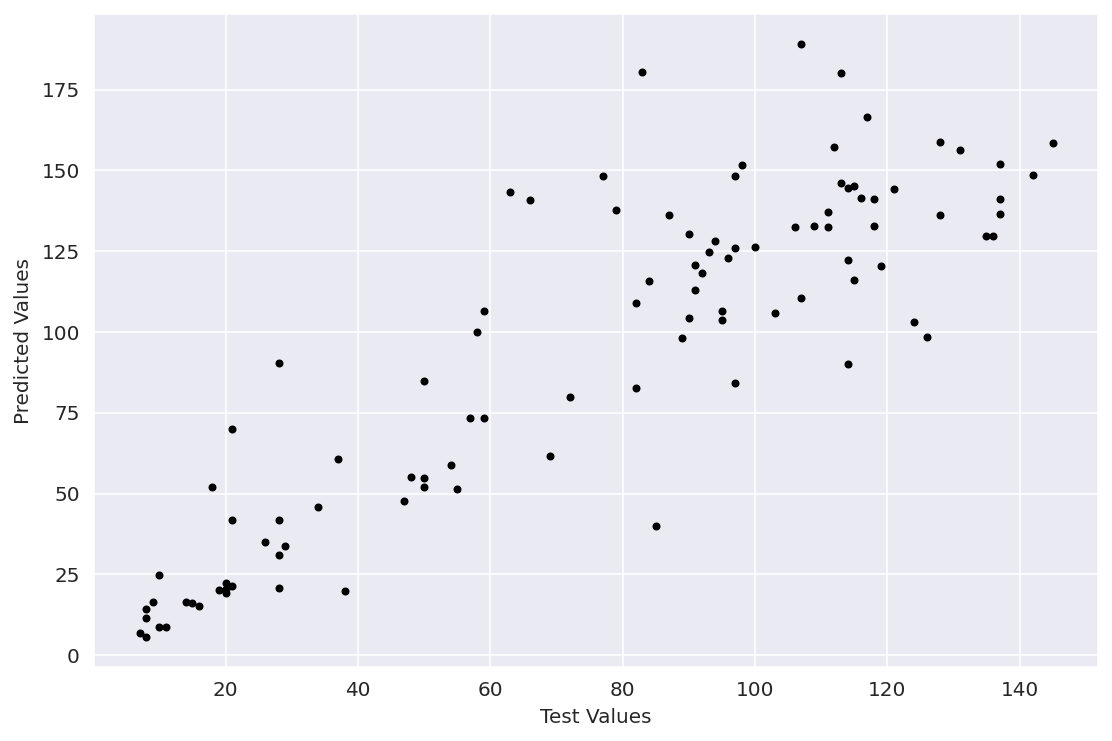

In [27]:
# from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train,y_train)

my_regression_results(rf_model)

Model r-squared score from test data: 0.4913
Mean squared error on test data: 878.38
Root mean squared error on test data: 29.64


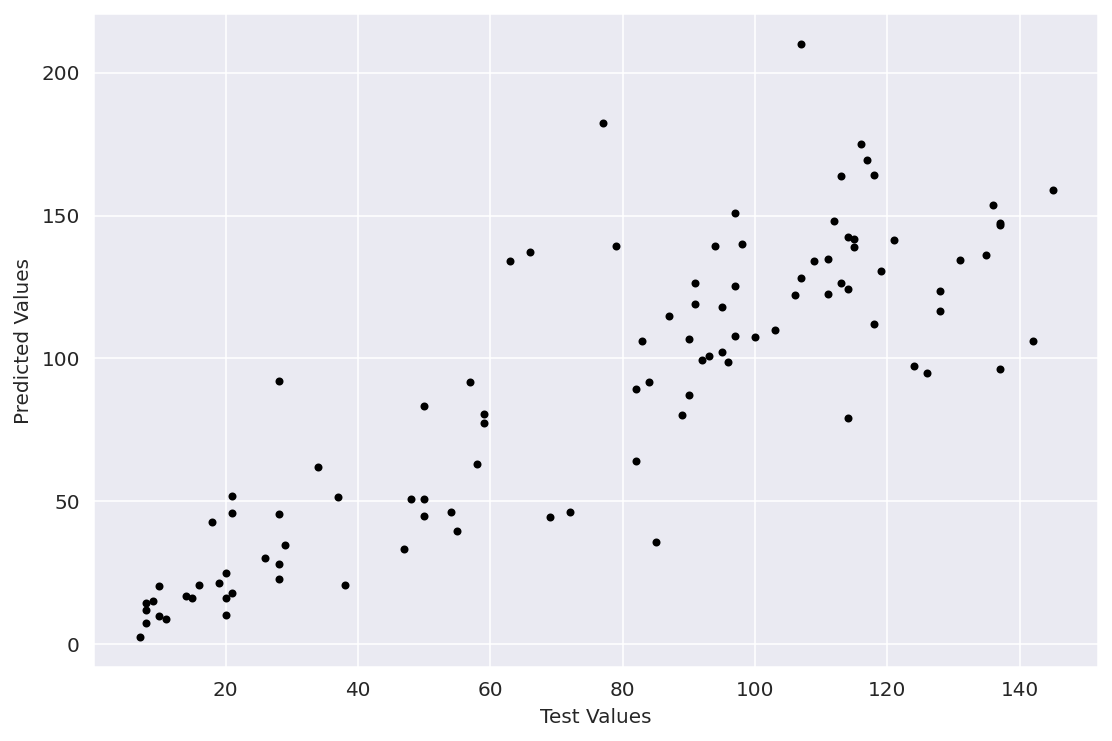

In [28]:
# import xgboost as xgb

xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgbr_model.fit(X_train,y_train)

my_regression_results(xgbr_model)

##### Model Results Following Changes after Proposal 2

In [29]:
d = {'Algorithm' : ['Linear Regression', 'Random Forest Regression','XGBoost Regression' ]
     ,'Data Transformations':['Adding Lagged Aggregates','..','..']
     ,'Train R-squared':[round(model_lr.score(X_train,y_train),2),round(rf_model.score(X_train,y_train),2),round(xgbr_model.score(X_train,y_train),2)]
     ,'Test R-squared':[round(my_short_regression_results(model_lr)[0],2),round(my_short_regression_results(rf_model)[0],2),round(my_short_regression_results(xgbr_model)[0],2)]
     ,'Test Mean Squared Error':[round(my_short_regression_results(model_lr)[1],2),round(my_short_regression_results(rf_model)[1],2),round(my_short_regression_results(xgbr_model)[1],2)]
     ,'Test Root Mean Squared Error':[round(my_short_regression_results(model_lr)[2],2),round(my_short_regression_results(rf_model)[2],2),round(my_short_regression_results(xgbr_model)[2],2)]}
df = pd.DataFrame(data=d)
df

,Algorithm,Data Transformations,Train R-squared,Test R-squared,Test Mean Squared Error,Test Root Mean Squared Error
0,Linear Regression,Adding Lagged Aggregates,0.62,0.50,855.63,29.25
1,Random Forest Regression,..,0.96,0.46,933.27,30.55
2,XGBoost Regression,..,0.94,0.49,878.38,29.64


##### Test for Multicollinearity

In [29]:
#take a small subset of 200 rows to assess issue quickly.
X_train_200 = X_train[:200]
#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vifs = {X_train_200.columns[i]:round(vif(X_train_200.values, i), 2) for i in range(len(X_train_200.columns))}
display(vifs)

{'T24': 28.97,
 'T30': 13.99,
 'T50': 64.43,
 'P15': 0.0,
 'P30': 29.88,
 'Ps30': 57.73,
 'phi': 41.14,
 'NRc': 36.21,
 'BPR': 42.53,
 'htBleed': 16.06,
 'W31': 20.46,
 'W32': 36.64,
 'Nf_diff': 62.74,
 'NRf_diff': 36.57,
 'T24_roll_median3': 84.65,
 'T30_roll_median3': 40.81,
 'T50_roll_median3': 204.54,
 'P15_roll_median3': 0.0,
 'P30_roll_median3': 79.95,
 'Ps30_roll_median3': 171.09,
 'phi_roll_median3': 126.69,
 'NRc_roll_median3': 94.48,
 'BPR_roll_median3': 79.43,
 'htBleed_roll_median3': 42.86,
 'W31_roll_median3': 39.22,
 'W32_roll_median3': 78.11,
 'Nf_diff_roll_median3': 147.94,
 'NRf_diff_roll_median3': 196.91,
 'T24_roll_median3_lag_1': 62.88,
 'T30_roll_median3_lag_1': 35.0,
 'T50_roll_median3_lag_1': 160.94,
 'P15_roll_median3_lag_1': 0.0,
 'P30_roll_median3_lag_1': 101.48,
 'Ps30_roll_median3_lag_1': 155.24,
 'phi_roll_median3_lag_1': 106.15,
 'NRc_roll_median3_lag_1': 75.95,
 'BPR_roll_median3_lag_1': 58.95,
 'htBleed_roll_median3_lag_1': 48.93,
 'W31_roll_median3_lag_

We have high multicollinearity, which is unacceptable for a multiple linear regression model, where we are shooting VIFs around ~5. We should start with fewer lags and assess which are most critical to keep in our model. 

In [30]:
# define filepath to read data
dir_path = './data/'

# define column names for easy indexing
index_names = ['unit_number', 'time_in_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# add remaining useful life
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

#take the difference of variables from their demanded levels. 
train['Nf_diff']=train['Nf']-train['Nf_dmd']
train['NRf_diff'] = train['NRf']-train['PCNfR_dmd']
test['Nf_diff']=test['Nf']-test['Nf_dmd']
test['NRf_diff'] = test['NRf']-test['PCNfR_dmd']

# drop unwanted columns and split target variable from training set
drop_sensors = ['T2', 'P2','epr','farB','Nf_dmd','PCNfR_dmd','Nc','Nf','NRf'] # observe rationale in Predictive Maintenance EDA and Feature Engineering file, where these variables produce no additional data.  
drop_labels = setting_names+drop_sensors # alter this version of the work to keep RUL and Unit number, as we need these to add lags and aggregates. 

X_train = train.drop(drop_labels, axis=1)
#y_train = X_train.pop('RUL') #do this later following transformations.
remaining_sensors = X_train.columns.difference(index_names+['RUL'])

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
#X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)
X_test = test.drop(drop_labels, axis=1)

print(X_train.columns)  # check remaining columns

Index(['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P15', 'P30',
       'Ps30', 'phi', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'RUL', 'Nf_diff',
       'NRf_diff'],
      dtype='object')


In [31]:
#prepare X_train. 

#apply rolling aggregates to train. 
grouped_df=X_train.groupby(['unit_number'])
dflist = [add_rolling_agg_variables(g, grouped_df.get_group(g),3) for g in grouped_df.groups.keys()]
X_train = pd.concat(dflist, axis=0).reset_index()

#apply lags to the aggregates in the short and long term. 
agg_columns=[col for col in X_train.columns if 'median' in col]
X_train = add_lagged_variables(X_train,1,agg_columns).reset_index(drop=True)

y_train = X_train.pop('RUL')

#Repeat for X_test. 

#apply rolling aggregates to test. 
grouped_df=X_test.groupby(['unit_number'])
dflist = [add_rolling_agg_variables(g, grouped_df.get_group(g),3) for g in grouped_df.groups.keys()]
X_test = pd.concat(dflist, axis=0).reset_index()

#apply lags to the aggregates in the short and long term. 
agg_columns=[col for col in X_test.columns if 'median' in col]
X_test = add_lagged_variables(X_test,1,agg_columns).reset_index(drop=True)

In [32]:
#clean out unhelpful columns from train and test sets. 

#start with train
group_columns=[col for col in X_train.columns if 'group' in col]
rul_columns=[col for col in X_train.columns if 'RUL' in col]
unit_number_columns=[col for col in X_train.columns if 'unit_number' in col]

drop_labels = group_columns+rul_columns+unit_number_columns+index_names
X_train = X_train.drop(drop_labels,axis=1)

#repeat for test
X_test = X_test.groupby('unit_number').last().reset_index()
group_columns=[col for col in X_test.columns if 'group' in col]
unit_number_columns=[col for col in X_test.columns if 'unit_number' in col]
drop_labels = group_columns+unit_number_columns+index_names
X_test = X_test.drop(drop_labels,axis=1)

In [33]:
X_test

,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,...,P30_roll_median3_lag_1,Ps30_roll_median3_lag_1,phi_roll_median3_lag_1,NRc_roll_median3_lag_1,BPR_roll_median3_lag_1,htBleed_roll_median3_lag_1,W31_roll_median3_lag_1,W32_roll_median3_lag_1,Nf_diff_roll_median3_lag_1,NRf_diff_roll_median3_lag_1
0,642.58,1581.22,1398.91,21.61,554.42,47.23,521.79,8130.11,8.4024,393,...,554.10,47.40,521.84,8134.79,8.4212,392.0,39.02,23.3621,0.08,2288.07
1,642.55,1586.59,1410.83,21.61,553.52,47.67,521.74,8126.90,8.4505,391,...,553.83,47.44,521.32,8128.77,8.4455,392.0,38.88,23.2918,0.11,2288.11
2,642.88,1589.75,1418.89,21.61,552.59,47.88,520.83,8131.46,8.4119,395,...,552.72,47.62,520.53,8128.02,8.4608,394.0,38.65,23.2330,0.19,2288.16
3,642.78,1594.53,1406.88,21.61,552.64,47.65,521.88,8133.64,8.4634,395,...,553.53,47.68,521.24,8134.72,8.4646,393.0,38.84,23.2586,0.15,2288.13
4,642.27,1589.94,1419.36,21.61,553.29,47.46,521.00,8125.74,8.4362,394,...,552.88,47.66,520.98,8129.61,8.4390,393.0,38.85,23.3016,0.10,2288.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,642.30,1590.88,1397.94,21.61,553.99,47.14,522.30,8148.24,8.4110,391,...,554.24,47.33,522.40,8150.93,8.4134,393.0,39.01,23.3963,0.03,2288.05
96,642.59,1582.96,1410.92,21.61,554.05,47.38,521.58,8155.48,8.4500,395,...,553.72,47.45,521.78,8154.37,8.4187,393.0,38.83,23.3713,0.03,2288.05
97,642.68,1599.51,1415.47,21.61,553.44,47.66,521.53,8146.39,8.4235,394,...,553.22,47.70,521.06,8140.75,8.4686,394.0,38.75,23.2662,0.10,2288.12
98,642.00,1585.03,1397.98,21.61,554.75,47.26,521.82,8150.38,8.4003,391,...,554.04,47.16,522.08,8150.53,8.3898,391.0,38.97,23.3901,-0.01,2288.01


In [34]:
y_train.shape

(20331,)

In [35]:
import statsmodels.api as sm
model_lr_1 = sm.OLS(y_train,X_train)
results = model_lr_1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    RUL   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              3576.
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                        0.00
Time:                        01:28:18   Log-Likelihood:                     -1.0559e+05
No. Observations:               20331   AIC:                                  2.113e+05
Df Residuals:                   20289   BIC:                                  2.116e+05
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [36]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'T24': 7007227.41,
 'T30': 244051.0,
 'T50': 188908.12,
 'P15': 284287163.1,
 'P30': 2875767.94,
 'Ps30': 335766.2,
 'phi': 4612328.75,
 'NRc': 8833885.05,
 'BPR': 273243.57,
 'htBleed': 248149.56,
 'W31': 227235.82,
 'W32': 231441.85,
 'Nf_diff': 23.33,
 'NRf_diff': 7566226542.23,
 'T24_roll_median3': 22657374.01,
 'T30_roll_median3': 788074.27,
 'T50_roll_median3': 613782.31,
 'P15_roll_median3': 1545031916.24,
 'P30_roll_median3': 9290778.24,
 'Ps30_roll_median3': 1070862.31,
 'phi_roll_median3': 14917786.92,
 'NRc_roll_median3': 31651094.18,
 'BPR_roll_median3': 879244.85,
 'htBleed_roll_median3': 674431.24,
 'W31_roll_median3': 740248.58,
 'W32_roll_median3': 731884.44,
 'Nf_diff_roll_median3': 72.92,
 'NRf_diff_roll_median3': 26548060017.69,
 'T24_roll_median3_lag_1': 16905595.15,
 'T30_roll_median3_lag_1': 591145.92,
 'T50_roll_median3_lag_1': 444860.53,
 'P15_roll_median3_lag_1': 1352161685.17,
 'P30_roll_median3_lag_1': 6711618.15,
 'Ps30_roll_median3_lag_1': 775734.93,
 'phi

In [37]:
#try scaling the data
scaler = StandardScaler()
scaler = StandardScaler().fit(X_train.values)
features = scaler.transform(X_train.values)
X_train = pd.DataFrame(features, columns = X_train.columns).reset_index(drop=True)
#X_train

#repeat for test
scaler = StandardScaler().fit(X_test.values)
features = scaler.transform(X_test.values)
X_test= pd.DataFrame(features, columns = X_test.columns).reset_index(drop=True)
X_test.head()

,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,...,P30_roll_median3_lag_1,Ps30_roll_median3_lag_1,phi_roll_median3_lag_1,NRc_roll_median3_lag_1,BPR_roll_median3_lag_1,htBleed_roll_median3_lag_1,W31_roll_median3_lag_1,W32_roll_median3_lag_1,Nf_diff_roll_median3_lag_1,NRf_diff_roll_median3_lag_1
0,-0.425894,-1.603619,-1.355943,0.100504,1.451228,-1.427840,0.739155,-0.657866,-1.537896,-0.356332,...,1.062337,-0.776049,0.879201,-0.395705,-0.910894,-1.122884,1.543964,0.973668,-0.487538,-0.701805
1,-0.493712,-0.791580,0.032832,0.100504,0.423689,0.292920,0.667113,-0.831042,-0.071375,-1.726838,...,0.728541,-0.605676,0.092715,-0.727660,-0.109869,-1.122884,0.648171,0.214525,-0.041619,-0.059421
2,0.252281,-0.313732,0.971886,0.100504,-0.638102,1.114192,-0.644059,-0.585035,-1.248251,1.014175,...,-0.643732,0.161003,-1.102140,-0.769016,0.394480,0.425922,-0.823490,-0.420433,1.147499,0.743560
3,0.026223,0.409090,-0.427375,0.100504,-0.581016,0.214704,0.868832,-0.467426,0.321934,1.014175,...,0.357656,0.416562,-0.028283,-0.399565,0.519743,-0.348481,0.392230,-0.143989,0.552940,0.261771
4,-1.126675,-0.285000,1.026645,0.100504,0.161095,-0.528352,-0.399115,-0.893623,-0.507368,0.328921,...,-0.445927,0.331376,-0.421527,-0.681340,-0.324135,-0.348481,0.456215,0.320352,-0.190259,0.101175


In [38]:
X_train.shape

(20331, 42)

In [39]:
y_train = y_train.reset_index(drop=True)

In [40]:
#import statsmodels.api as sm
model_lr_1 = sm.OLS(y_train,X_train)
results = model_lr_1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    RUL   R-squared (uncentered):                   0.172
Model:                            OLS   Adj. R-squared (uncentered):              0.170
Method:                 Least Squares   F-statistic:                              100.3
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                        0.00
Time:                        01:28:39   Log-Likelihood:                     -1.2531e+05
No. Observations:               20331   AIC:                                  2.507e+05
Df Residuals:                   20289   BIC:                                  2.510e+05
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

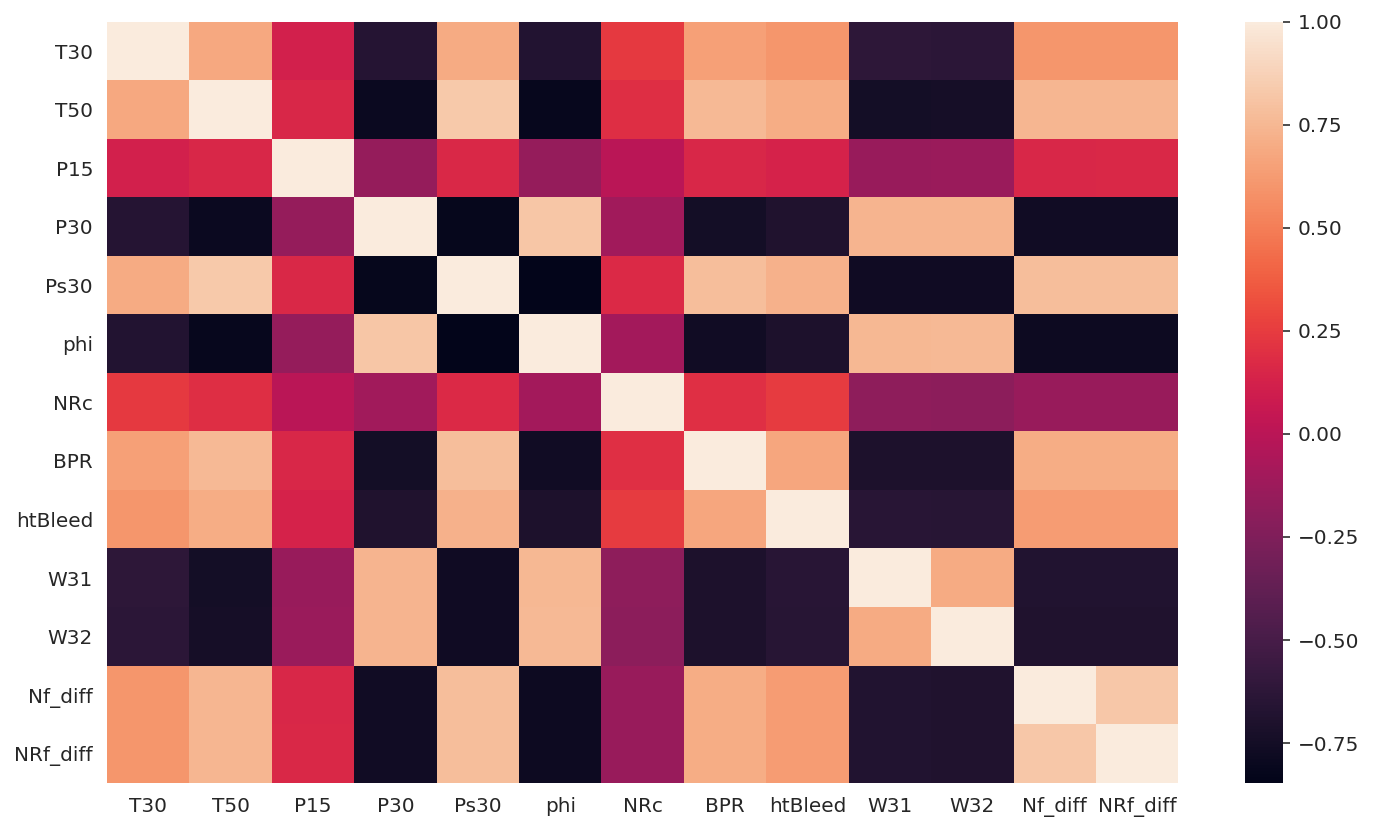

In [41]:
cormat = X_train_scaled.corr()
round(cormat,2)
sns.heatmap(cormat);

In [42]:
#attempt to drop the rolling median columns since they are heavily correlated with the lags 
cols = list(range(16,30))
x_train = X_train.drop(X_train.columns[cols],axis=1,inplace=True)
x_test = X_test.drop(X_test.columns[cols],axis=1,inplace=True)

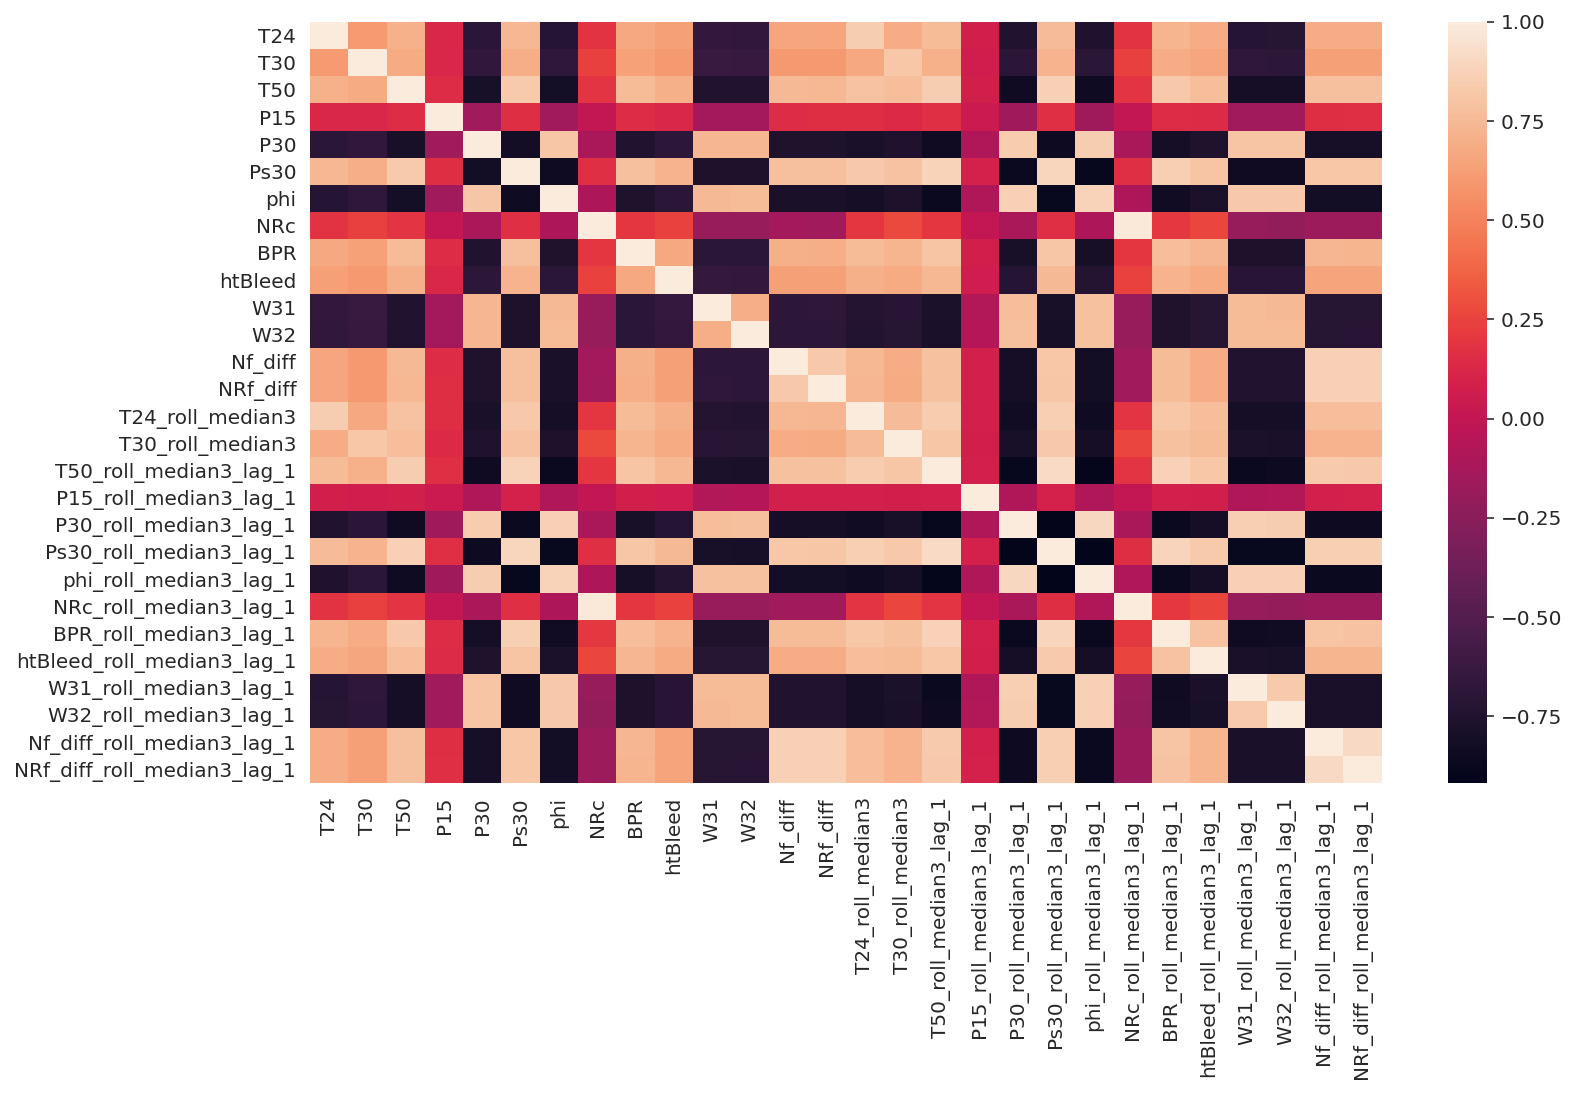

In [43]:
cormat = X_train.corr()
round(cormat,2)
sns.heatmap(cormat);

In [44]:
#import statsmodels.api as sm
model_lr_1 = sm.OLS(y_train,X_train)
results = model_lr_1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    RUL   R-squared (uncentered):                   0.172
Model:                            OLS   Adj. R-squared (uncentered):              0.171
Method:                 Least Squares   F-statistic:                              150.4
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                        0.00
Time:                        01:28:43   Log-Likelihood:                     -1.2531e+05
No. Observations:               20331   AIC:                                  2.507e+05
Df Residuals:                   20303   BIC:                                  2.509e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [45]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'T24': 3.63,
 'T30': 3.12,
 'T50': 4.89,
 'P15': 1.03,
 'P30': 4.6,
 'Ps30': 6.68,
 'phi': 5.75,
 'NRc': 24.64,
 'BPR': 3.45,
 'htBleed': 2.62,
 'W31': 3.16,
 'W32': 3.21,
 'Nf_diff': 5.08,
 'NRf_diff': 5.08,
 'T24_roll_median3': 6.24,
 'T30_roll_median3': 5.16,
 'T50_roll_median3_lag_1': 8.83,
 'P15_roll_median3_lag_1': 1.01,
 'P30_roll_median3_lag_1': 8.21,
 'Ps30_roll_median3_lag_1': 12.12,
 'phi_roll_median3_lag_1': 10.34,
 'NRc_roll_median3_lag_1': 26.08,
 'BPR_roll_median3_lag_1': 6.1,
 'htBleed_roll_median3_lag_1': 4.01,
 'W31_roll_median3_lag_1': 5.47,
 'W32_roll_median3_lag_1': 5.5,
 'Nf_diff_roll_median3_lag_1': 9.42,
 'NRf_diff_roll_median3_lag_1': 9.19}

In [46]:
#list variables with VIF > 5 to remove from the model:
{k for (k,v) in vifs.items() if v > 5}

{'BPR_roll_median3_lag_1',
 'NRc',
 'NRc_roll_median3_lag_1',
 'NRf_diff',
 'NRf_diff_roll_median3_lag_1',
 'Nf_diff',
 'Nf_diff_roll_median3_lag_1',
 'P30_roll_median3_lag_1',
 'Ps30',
 'Ps30_roll_median3_lag_1',
 'T24_roll_median3',
 'T30_roll_median3',
 'T50_roll_median3_lag_1',
 'W31_roll_median3_lag_1',
 'W32_roll_median3_lag_1',
 'phi',
 'phi_roll_median3_lag_1'}

In [47]:
cols = ['BPR_roll_median3_lag_1','NRc',
 'NRc_roll_median3_lag_1',
 'NRf_diff',
 'NRf_diff_roll_median3_lag_1',
 'Nf_diff',
 'Nf_diff_roll_median3_lag_1',
 'P30_roll_median3_lag_1',
 'Ps30',
 'Ps30_roll_median3_lag_1',
 'T50_roll_median3_lag_1',
 'W31_roll_median3_lag_1',
 'W32_roll_median3_lag_1',
 'phi',
 'phi_roll_median3_lag_1']
x_train = X_train.drop(cols,axis=1,inplace=True)
x_test = X_test.drop(cols,axis=1,inplace=True)

In [48]:
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'T24': 3.61,
 'T30': 3.1,
 'T50': 4.32,
 'P15': 1.03,
 'P30': 3.93,
 'BPR': 3.22,
 'htBleed': 2.48,
 'W31': 2.97,
 'W32': 3.01,
 'T24_roll_median3': 5.85,
 'T30_roll_median3': 4.86,
 'P15_roll_median3_lag_1': 1.01,
 'htBleed_roll_median3_lag_1': 3.59}

In [49]:
model_lr_1 = sm.OLS(y_train,X_train)
results = model_lr_1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    RUL   R-squared (uncentered):                   0.163
Model:                            OLS   Adj. R-squared (uncentered):              0.162
Method:                 Least Squares   F-statistic:                              303.5
Date:                Thu, 25 Nov 2021   Prob (F-statistic):                        0.00
Time:                        01:28:55   Log-Likelihood:                     -1.2542e+05
No. Observations:               20331   AIC:                                  2.509e+05
Df Residuals:                   20318   BIC:                                  2.510e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

Model r-squared score from test data: -0.0096
Mean squared error on test data: 1743.48
Root mean squared error on test data: 41.75


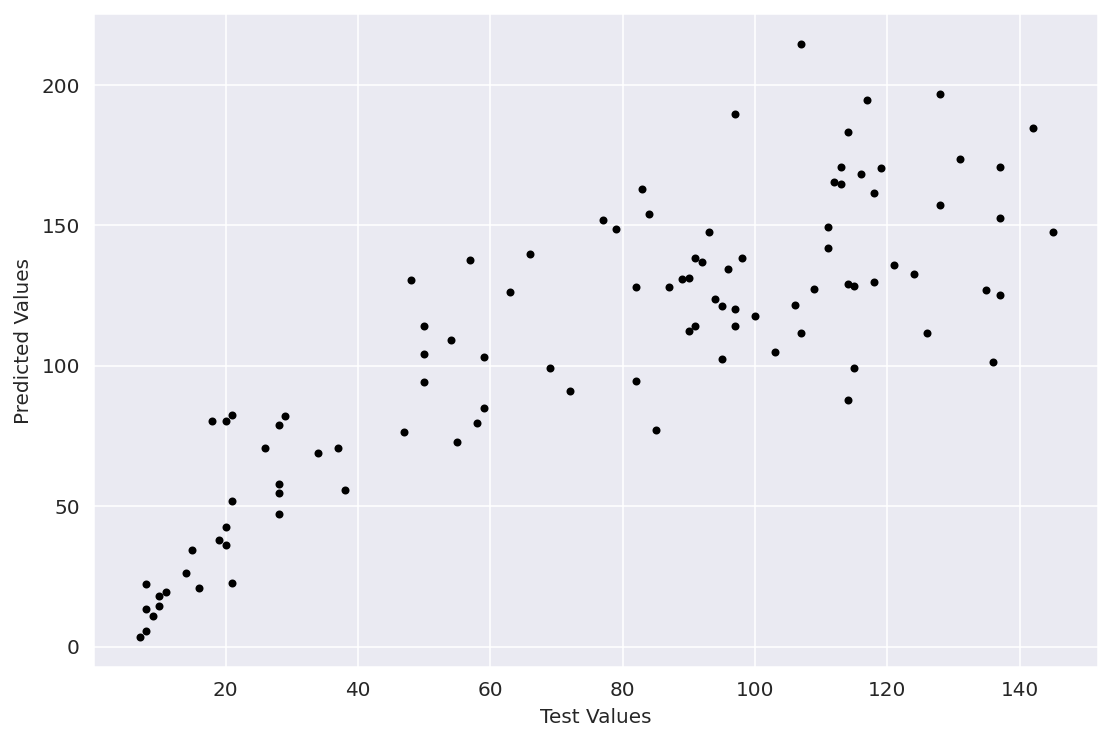

In [50]:
#model lr again to see if we've improved over baseline since removing multicollinearity
model_lr_2= LinearRegression()
model_lr_2.fit(X_train,y_train)

my_regression_results(model_lr_2)

### Multicollinearity Cleanup Results

In [51]:
d = {'Algorithm' : ['Linear Regression' ]
     ,'Data Transformations':['Addressing Multicollinearity']
     ,'Train R-squared':[round(model_lr_2.score(X_train,y_train),2)]
     ,'Test R-squared':[round(my_short_regression_results(model_lr_2)[0],2)]
     ,'Test Mean Squared Error':[round(my_short_regression_results(model_lr_2)[1],2)]
     ,'Test Root Mean Squared Error':[round(my_short_regression_results(model_lr_2)[2],2)]}
df = pd.DataFrame(data=d)
df

,Algorithm,Data Transformations,Train R-squared,Test R-squared,Test Mean Squared Error,Test Root Mean Squared Error
0,Linear Regression,Addressing Multicollinearity,0.56,-0.01,1743.48,41.75


##### Proposal 3: Tune the Hyperparameters on the Tree-based Models

Due to the fact we now have a large number of variables to contend with, use a Random Search CV process to tune hyperparameters of both the random forest regression and xgboost models. I'll use the following sources as a guide to implementation:
* Prescriptive Analytics, Project 2 Hyperparameter Optimization Project P
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
* https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

Our most useful models have been from the tree-based models run on the dataset with the 10 lags and rolling aggregates. What would happen if we tuned the hyperparmeters? For a direct comparison to past approaches, we must stay consistent with the same X train and X test transformations we had last time we trained these models. 


In [27]:
X_train.head()

,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,...,P30_roll_median3_lag_10,Ps30_roll_median3_lag_10,phi_roll_median3_lag_10,NRc_roll_median3_lag_10,BPR_roll_median3_lag_10,htBleed_roll_median3_lag_10,W31_roll_median3_lag_10,W32_roll_median3_lag_10,Nf_diff_roll_median3_lag_10,NRf_diff_roll_median3_lag_10
10,643.07,1582.19,1400.83,21.61,553.44,47.38,521.85,8128.10,8.4152,393,...,554.26,47.47,522.28,8133.23,8.4195,392.0,39.00,23.4190,0.06,2288.03
11,642.35,1592.95,1399.16,21.61,554.48,47.44,521.67,8134.43,8.3964,393,...,554.26,47.27,522.42,8133.23,8.4178,392.0,38.95,23.3739,0.08,2288.07
12,642.43,1583.82,1402.13,21.61,553.64,47.30,522.50,8127.56,8.4199,391,...,554.26,47.27,522.42,8133.80,8.4178,392.0,38.90,23.3739,0.08,2288.04
13,642.13,1587.98,1404.50,21.61,553.94,47.24,521.49,8136.11,8.3936,392,...,554.45,47.16,522.19,8133.80,8.4108,392.0,38.90,23.3739,0.06,2288.04
14,642.58,1584.96,1399.95,21.61,553.80,47.12,521.89,8137.27,8.4542,392,...,554.34,47.28,522.19,8132.85,8.4108,392.0,38.98,23.3774,0.02,2288.03


In [28]:
X_test.head()

,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,...,P30_roll_median3_lag_10,Ps30_roll_median3_lag_10,phi_roll_median3_lag_10,NRc_roll_median3_lag_10,BPR_roll_median3_lag_10,htBleed_roll_median3_lag_10,W31_roll_median3_lag_10,W32_roll_median3_lag_10,Nf_diff_roll_median3_lag_10,NRf_diff_roll_median3_lag_10
0,642.58,1581.22,1398.91,21.61,554.42,47.23,521.79,8130.11,8.4024,393,...,554.31,47.36,522.06,8128.59,8.4099,392.0,39.00,23.3809,0.05,2288.05
1,642.55,1586.59,1410.83,21.61,553.52,47.67,521.74,8126.90,8.4505,391,...,553.49,47.50,521.74,8128.53,8.4363,393.0,38.81,23.3072,0.10,2288.13
2,642.88,1589.75,1418.89,21.61,552.59,47.88,520.83,8131.46,8.4119,395,...,553.41,47.68,521.06,8131.67,8.4621,393.0,38.85,23.2683,0.14,2288.17
3,642.78,1594.53,1406.88,21.61,552.64,47.65,521.88,8133.64,8.4634,395,...,553.18,47.58,521.59,8128.48,8.4347,393.0,38.79,23.2455,0.10,2288.14
4,642.27,1589.94,1419.36,21.61,553.29,47.46,521.00,8125.74,8.4362,394,...,553.08,47.66,521.20,8131.07,8.4380,393.0,38.78,23.2643,0.08,2288.12


In [32]:
#from pprint import pprint
pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [35]:
# RandomizedSearchCV for Random Forest Model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

params = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    random_state=8675309,
    n_iter=10,
    cv=5,
    verbose=20,
    n_jobs=1,
    return_train_score=True)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


KeyboardInterrupt: 

In [0]:
random_search_rf.best_params_

In [0]:
my_regression_results(random_search_rf)

In [36]:
#from pprint import pprint
pprint(xgbr_model.get_xgb_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


In [29]:
# RandomizedSearchCV for XGBoost Re

params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": randint(1, 10),
    "n_estimators": randint(10, 150),
    "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
    "min_child_weight": randint(1, 20),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5)
}

random_search_xgb = RandomizedSearchCV(
    xgbr_model,
    param_distributions=params,
    random_state=8675309,
    n_iter=25,
    cv=5,
    verbose=5,
    n_jobs=1,
    return_train_score=True)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV 1/5] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=59, reg_alpha=1.9246298227087082, reg_lambda=0.3316188261704417, subsample=0.22311182286022002;, score=(train=-0.272, test=-0.266) total time=  13.6s


[CV 2/5] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=59, reg_alpha=1.9246298227087082, reg_lambda=0.3316188261704417, subsample=0.22311182286022002;, score=(train=-0.281, test=-0.085) total time=   9.8s


[CV 3/5] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=59, reg_alpha=1.9246298227087082, reg_lambda=0.3316188261704417, subsample=0.22311182286022002;, score=(train=-0.260, test=-0.229) total time=  10.0s


[CV 4/5] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=59, reg_alpha=1.9246298227087082, reg_lambda=0.3316188261704417, subsample=0.22311182286022002;, score=(train=-0.267, test=-0.490) total time=   9.2s


[CV 5/5] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=59, reg_alpha=1.9246298227087082, reg_lambda=0.3316188261704417, subsample=0.22311182286022002;, score=(train=-0.293, test=-0.434) total time=   9.5s


[CV 1/5] END learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=113, reg_alpha=3.864656460258445, reg_lambda=1.7725646250966287, subsample=0.5687129957781784;, score=(train=0.888, test=-0.118) total time=  25.8s


[CV 2/5] END learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=113, reg_alpha=3.864656460258445, reg_lambda=1.7725646250966287, subsample=0.5687129957781784;, score=(train=0.890, test=-0.335) total time=  26.2s


[CV 3/5] END learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=113, reg_alpha=3.864656460258445, reg_lambda=1.7725646250966287, subsample=0.5687129957781784;, score=(train=0.892, test=-0.343) total time=  26.4s


[CV 4/5] END learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=113, reg_alpha=3.864656460258445, reg_lambda=1.7725646250966287, subsample=0.5687129957781784;, score=(train=0.900, test=0.066) total time=  30.2s


[CV 5/5] END learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=113, reg_alpha=3.864656460258445, reg_lambda=1.7725646250966287, subsample=0.5687129957781784;, score=(train=0.892, test=0.142) total time=  26.9s


[CV 1/5] END learning_rate=1.0, max_depth=7, min_child_weight=13, n_estimators=69, reg_alpha=1.314186413925611, reg_lambda=1.6249604806868296, subsample=0.800561791391917;, score=(train=0.978, test=0.282) total time=  22.0s


[CV 2/5] END learning_rate=1.0, max_depth=7, min_child_weight=13, n_estimators=69, reg_alpha=1.314186413925611, reg_lambda=1.6249604806868296, subsample=0.800561791391917;, score=(train=0.977, test=-0.030) total time=  25.2s


[CV 3/5] END learning_rate=1.0, max_depth=7, min_child_weight=13, n_estimators=69, reg_alpha=1.314186413925611, reg_lambda=1.6249604806868296, subsample=0.800561791391917;, score=(train=0.976, test=0.091) total time=  22.7s


[CV 4/5] END learning_rate=1.0, max_depth=7, min_child_weight=13, n_estimators=69, reg_alpha=1.314186413925611, reg_lambda=1.6249604806868296, subsample=0.800561791391917;, score=(train=0.977, test=0.225) total time=  22.6s


[CV 5/5] END learning_rate=1.0, max_depth=7, min_child_weight=13, n_estimators=69, reg_alpha=1.314186413925611, reg_lambda=1.6249604806868296, subsample=0.800561791391917;, score=(train=0.978, test=0.275) total time=  25.7s


[CV 1/5] END learning_rate=1.0, max_depth=1, min_child_weight=6, n_estimators=139, reg_alpha=0.5666159831855222, reg_lambda=4.106293918592037, subsample=0.9592587591943247;, score=(train=0.670, test=0.690) total time=   7.3s


[CV 2/5] END learning_rate=1.0, max_depth=1, min_child_weight=6, n_estimators=139, reg_alpha=0.5666159831855222, reg_lambda=4.106293918592037, subsample=0.9592587591943247;, score=(train=0.680, test=0.621) total time=   7.3s


[CV 3/5] END learning_rate=1.0, max_depth=1, min_child_weight=6, n_estimators=139, reg_alpha=0.5666159831855222, reg_lambda=4.106293918592037, subsample=0.9592587591943247;, score=(train=0.687, test=0.608) total time=   7.6s


[CV 4/5] END learning_rate=1.0, max_depth=1, min_child_weight=6, n_estimators=139, reg_alpha=0.5666159831855222, reg_lambda=4.106293918592037, subsample=0.9592587591943247;, score=(train=0.717, test=0.498) total time=   7.7s


[CV 5/5] END learning_rate=1.0, max_depth=1, min_child_weight=6, n_estimators=139, reg_alpha=0.5666159831855222, reg_lambda=4.106293918592037, subsample=0.9592587591943247;, score=(train=0.701, test=0.578) total time=   7.1s


[CV 1/5] END learning_rate=0.5, max_depth=8, min_child_weight=13, n_estimators=54, reg_alpha=4.273531344366107, reg_lambda=0.3614847715291919, subsample=0.9827539273587139;, score=(train=0.981, test=0.633) total time=  22.7s


[CV 2/5] END learning_rate=0.5, max_depth=8, min_child_weight=13, n_estimators=54, reg_alpha=4.273531344366107, reg_lambda=0.3614847715291919, subsample=0.9827539273587139;, score=(train=0.981, test=0.466) total time=  19.1s


[CV 3/5] END learning_rate=0.5, max_depth=8, min_child_weight=13, n_estimators=54, reg_alpha=4.273531344366107, reg_lambda=0.3614847715291919, subsample=0.9827539273587139;, score=(train=0.982, test=0.490) total time=  19.0s


[CV 4/5] END learning_rate=0.5, max_depth=8, min_child_weight=13, n_estimators=54, reg_alpha=4.273531344366107, reg_lambda=0.3614847715291919, subsample=0.9827539273587139;, score=(train=0.984, test=0.452) total time=  22.8s


[CV 5/5] END learning_rate=0.5, max_depth=8, min_child_weight=13, n_estimators=54, reg_alpha=4.273531344366107, reg_lambda=0.3614847715291919, subsample=0.9827539273587139;, score=(train=0.982, test=0.513) total time=  18.2s


[CV 1/5] END learning_rate=0.001, max_depth=5, min_child_weight=2, n_estimators=63, reg_alpha=0.9801878684826565, reg_lambda=3.2440249335232716, subsample=0.6101293473191399;, score=(train=-1.978, test=-2.206) total time=  16.1s


[CV 2/5] END learning_rate=0.001, max_depth=5, min_child_weight=2, n_estimators=63, reg_alpha=0.9801878684826565, reg_lambda=3.2440249335232716, subsample=0.6101293473191399;, score=(train=-2.021, test=-2.208) total time=  14.3s


[CV 3/5] END learning_rate=0.001, max_depth=5, min_child_weight=2, n_estimators=63, reg_alpha=0.9801878684826565, reg_lambda=3.2440249335232716, subsample=0.6101293473191399;, score=(train=-1.974, test=-2.241) total time=  18.1s


[CV 4/5] END learning_rate=0.001, max_depth=5, min_child_weight=2, n_estimators=63, reg_alpha=0.9801878684826565, reg_lambda=3.2440249335232716, subsample=0.6101293473191399;, score=(train=-2.053, test=-1.984) total time=  16.4s


[CV 5/5] END learning_rate=0.001, max_depth=5, min_child_weight=2, n_estimators=63, reg_alpha=0.9801878684826565, reg_lambda=3.2440249335232716, subsample=0.6101293473191399;, score=(train=-2.102, test=-1.916) total time=  15.1s


[CV 1/5] END learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=92, reg_alpha=0.8102793670033459, reg_lambda=4.0640825981722015, subsample=0.7864895093687088;, score=(train=-1.830, test=-2.038) total time=  33.4s


[CV 2/5] END learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=92, reg_alpha=0.8102793670033459, reg_lambda=4.0640825981722015, subsample=0.7864895093687088;, score=(train=-1.871, test=-2.020) total time=  32.6s


[CV 3/5] END learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=92, reg_alpha=0.8102793670033459, reg_lambda=4.0640825981722015, subsample=0.7864895093687088;, score=(train=-1.826, test=-2.066) total time=  38.5s


[CV 4/5] END learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=92, reg_alpha=0.8102793670033459, reg_lambda=4.0640825981722015, subsample=0.7864895093687088;, score=(train=-1.898, test=-1.863) total time=  35.9s


[CV 5/5] END learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=92, reg_alpha=0.8102793670033459, reg_lambda=4.0640825981722015, subsample=0.7864895093687088;, score=(train=-1.945, test=-1.793) total time=  34.8s


[CV 1/5] END learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=82, reg_alpha=0.30321968913636976, reg_lambda=2.1414785142199557, subsample=0.1011386086671309;, score=(train=0.045, test=0.087) total time=   9.8s


[CV 2/5] END learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=82, reg_alpha=0.30321968913636976, reg_lambda=2.1414785142199557, subsample=0.1011386086671309;, score=(train=0.045, test=0.276) total time=   9.6s


[CV 3/5] END learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=82, reg_alpha=0.30321968913636976, reg_lambda=2.1414785142199557, subsample=0.1011386086671309;, score=(train=0.059, test=0.131) total time=  15.3s


[CV 4/5] END learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=82, reg_alpha=0.30321968913636976, reg_lambda=2.1414785142199557, subsample=0.1011386086671309;, score=(train=0.068, test=-0.193) total time=  14.9s


[CV 5/5] END learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=82, reg_alpha=0.30321968913636976, reg_lambda=2.1414785142199557, subsample=0.1011386086671309;, score=(train=0.049, test=-0.131) total time=  14.3s


[CV 1/5] END learning_rate=0.01, max_depth=4, min_child_weight=8, n_estimators=111, reg_alpha=0.7229439539293253, reg_lambda=0.3349256024541525, subsample=0.7008610044172657;, score=(train=0.310, test=0.383) total time=  25.9s


[CV 2/5] END learning_rate=0.01, max_depth=4, min_child_weight=8, n_estimators=111, reg_alpha=0.7229439539293253, reg_lambda=0.3349256024541525, subsample=0.7008610044172657;, score=(train=0.315, test=0.528) total time=  22.8s


[CV 3/5] END learning_rate=0.01, max_depth=4, min_child_weight=8, n_estimators=111, reg_alpha=0.7229439539293253, reg_lambda=0.3349256024541525, subsample=0.7008610044172657;, score=(train=0.327, test=0.417) total time=  24.6s


[CV 4/5] END learning_rate=0.01, max_depth=4, min_child_weight=8, n_estimators=111, reg_alpha=0.7229439539293253, reg_lambda=0.3349256024541525, subsample=0.7008610044172657;, score=(train=0.346, test=0.078) total time=  21.0s


[CV 5/5] END learning_rate=0.01, max_depth=4, min_child_weight=8, n_estimators=111, reg_alpha=0.7229439539293253, reg_lambda=0.3349256024541525, subsample=0.7008610044172657;, score=(train=0.328, test=0.120) total time=  21.0s


[CV 1/5] END learning_rate=0.001, max_depth=7, min_child_weight=6, n_estimators=29, reg_alpha=1.886943911774372, reg_lambda=2.9210985939085354, subsample=0.7971405738498868;, score=(train=-2.158, test=-2.411) total time=  13.2s


[CV 2/5] END learning_rate=0.001, max_depth=7, min_child_weight=6, n_estimators=29, reg_alpha=1.886943911774372, reg_lambda=2.9210985939085354, subsample=0.7971405738498868;, score=(train=-2.206, test=-2.444) total time=  10.0s


[CV 3/5] END learning_rate=0.001, max_depth=7, min_child_weight=6, n_estimators=29, reg_alpha=1.886943911774372, reg_lambda=2.9210985939085354, subsample=0.7971405738498868;, score=(train=-2.155, test=-2.460) total time=  10.9s


[CV 4/5] END learning_rate=0.001, max_depth=7, min_child_weight=6, n_estimators=29, reg_alpha=1.886943911774372, reg_lambda=2.9210985939085354, subsample=0.7971405738498868;, score=(train=-2.241, test=-2.140) total time=  10.1s


[CV 5/5] END learning_rate=0.001, max_depth=7, min_child_weight=6, n_estimators=29, reg_alpha=1.886943911774372, reg_lambda=2.9210985939085354, subsample=0.7971405738498868;, score=(train=-2.293, test=-2.068) total time=  10.3s


[CV 1/5] END learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=115, reg_alpha=1.1298003538030903, reg_lambda=4.607840214514044, subsample=0.7428130082444454;, score=(train=0.667, test=0.728) total time=  10.9s


[CV 2/5] END learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=115, reg_alpha=1.1298003538030903, reg_lambda=4.607840214514044, subsample=0.7428130082444454;, score=(train=0.679, test=0.641) total time=  13.1s


[CV 3/5] END learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=115, reg_alpha=1.1298003538030903, reg_lambda=4.607840214514044, subsample=0.7428130082444454;, score=(train=0.684, test=0.649) total time=  13.7s


[CV 4/5] END learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=115, reg_alpha=1.1298003538030903, reg_lambda=4.607840214514044, subsample=0.7428130082444454;, score=(train=0.718, test=0.495) total time=  11.4s


[CV 5/5] END learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=115, reg_alpha=1.1298003538030903, reg_lambda=4.607840214514044, subsample=0.7428130082444454;, score=(train=0.703, test=0.578) total time=  11.5s


[CV 1/5] END learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=130, reg_alpha=4.175359500017819, reg_lambda=1.5219206856594676, subsample=0.5325715834283595;, score=(train=0.987, test=0.514) total time=  45.5s


[CV 2/5] END learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=130, reg_alpha=4.175359500017819, reg_lambda=1.5219206856594676, subsample=0.5325715834283595;, score=(train=0.988, test=0.275) total time=  43.5s


[CV 3/5] END learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=130, reg_alpha=4.175359500017819, reg_lambda=1.5219206856594676, subsample=0.5325715834283595;, score=(train=0.987, test=0.377) total time=  47.0s


[CV 4/5] END learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=130, reg_alpha=4.175359500017819, reg_lambda=1.5219206856594676, subsample=0.5325715834283595;, score=(train=0.989, test=0.403) total time=  46.9s


[CV 5/5] END learning_rate=0.5, max_depth=7, min_child_weight=12, n_estimators=130, reg_alpha=4.175359500017819, reg_lambda=1.5219206856594676, subsample=0.5325715834283595;, score=(train=0.987, test=0.415) total time=  42.1s


[CV 1/5] END learning_rate=0.01, max_depth=9, min_child_weight=14, n_estimators=105, reg_alpha=2.7044406556842597, reg_lambda=3.833684466432273, subsample=0.07410363925406072;, score=(train=0.232, test=0.287) total time=  20.2s


[CV 2/5] END learning_rate=0.01, max_depth=9, min_child_weight=14, n_estimators=105, reg_alpha=2.7044406556842597, reg_lambda=3.833684466432273, subsample=0.07410363925406072;, score=(train=0.240, test=0.468) total time=  16.8s


[CV 3/5] END learning_rate=0.01, max_depth=9, min_child_weight=14, n_estimators=105, reg_alpha=2.7044406556842597, reg_lambda=3.833684466432273, subsample=0.07410363925406072;, score=(train=0.253, test=0.337) total time=  16.5s


[CV 4/5] END learning_rate=0.01, max_depth=9, min_child_weight=14, n_estimators=105, reg_alpha=2.7044406556842597, reg_lambda=3.833684466432273, subsample=0.07410363925406072;, score=(train=0.271, test=-0.006) total time=  16.0s


[CV 5/5] END learning_rate=0.01, max_depth=9, min_child_weight=14, n_estimators=105, reg_alpha=2.7044406556842597, reg_lambda=3.833684466432273, subsample=0.07410363925406072;, score=(train=0.252, test=0.049) total time=  18.6s


[CV 1/5] END learning_rate=0.5, max_depth=8, min_child_weight=17, n_estimators=132, reg_alpha=3.8459613531115067, reg_lambda=3.8956558562223464, subsample=0.3056455306481505;, score=(train=0.948, test=0.172) total time=  39.6s


[CV 2/5] END learning_rate=0.5, max_depth=8, min_child_weight=17, n_estimators=132, reg_alpha=3.8459613531115067, reg_lambda=3.8956558562223464, subsample=0.3056455306481505;, score=(train=0.952, test=-0.075) total time=  41.9s


[CV 3/5] END learning_rate=0.5, max_depth=8, min_child_weight=17, n_estimators=132, reg_alpha=3.8459613531115067, reg_lambda=3.8956558562223464, subsample=0.3056455306481505;, score=(train=0.947, test=-0.047) total time=  39.4s


[CV 4/5] END learning_rate=0.5, max_depth=8, min_child_weight=17, n_estimators=132, reg_alpha=3.8459613531115067, reg_lambda=3.8956558562223464, subsample=0.3056455306481505;, score=(train=0.955, test=0.216) total time=  42.6s


[CV 5/5] END learning_rate=0.5, max_depth=8, min_child_weight=17, n_estimators=132, reg_alpha=3.8459613531115067, reg_lambda=3.8956558562223464, subsample=0.3056455306481505;, score=(train=0.953, test=0.237) total time=  43.6s


[CV 1/5] END learning_rate=0.5, max_depth=5, min_child_weight=19, n_estimators=45, reg_alpha=1.7344939796082244, reg_lambda=0.7232156315891902, subsample=0.943862478733438;, score=(train=0.858, test=0.647) total time=  10.7s


[CV 2/5] END learning_rate=0.5, max_depth=5, min_child_weight=19, n_estimators=45, reg_alpha=1.7344939796082244, reg_lambda=0.7232156315891902, subsample=0.943862478733438;, score=(train=0.866, test=0.521) total time=   9.8s


[CV 3/5] END learning_rate=0.5, max_depth=5, min_child_weight=19, n_estimators=45, reg_alpha=1.7344939796082244, reg_lambda=0.7232156315891902, subsample=0.943862478733438;, score=(train=0.872, test=0.544) total time=   9.5s


[CV 4/5] END learning_rate=0.5, max_depth=5, min_child_weight=19, n_estimators=45, reg_alpha=1.7344939796082244, reg_lambda=0.7232156315891902, subsample=0.943862478733438;, score=(train=0.871, test=0.494) total time=   9.7s


[CV 5/5] END learning_rate=0.5, max_depth=5, min_child_weight=19, n_estimators=45, reg_alpha=1.7344939796082244, reg_lambda=0.7232156315891902, subsample=0.943862478733438;, score=(train=0.866, test=0.550) total time=  11.2s


[CV 1/5] END learning_rate=0.001, max_depth=8, min_child_weight=18, n_estimators=46, reg_alpha=1.2785771298063353, reg_lambda=2.9170626991390614, subsample=0.9831650802396265;, score=(train=-2.064, test=-2.306) total time=  19.6s


[CV 2/5] END learning_rate=0.001, max_depth=8, min_child_weight=18, n_estimators=46, reg_alpha=1.2785771298063353, reg_lambda=2.9170626991390614, subsample=0.9831650802396265;, score=(train=-2.110, test=-2.322) total time=  17.0s


[CV 3/5] END learning_rate=0.001, max_depth=8, min_child_weight=18, n_estimators=46, reg_alpha=1.2785771298063353, reg_lambda=2.9170626991390614, subsample=0.9831650802396265;, score=(train=-2.061, test=-2.349) total time=  17.6s


[CV 4/5] END learning_rate=0.001, max_depth=8, min_child_weight=18, n_estimators=46, reg_alpha=1.2785771298063353, reg_lambda=2.9170626991390614, subsample=0.9831650802396265;, score=(train=-2.143, test=-2.063) total time=  21.8s


[CV 5/5] END learning_rate=0.001, max_depth=8, min_child_weight=18, n_estimators=46, reg_alpha=1.2785771298063353, reg_lambda=2.9170626991390614, subsample=0.9831650802396265;, score=(train=-2.194, test=-1.989) total time=  17.4s


[CV 1/5] END learning_rate=1.0, max_depth=1, min_child_weight=4, n_estimators=131, reg_alpha=3.1041629785855616, reg_lambda=0.01929629964663948, subsample=0.40982956946412674;, score=(train=0.655, test=0.668) total time=   7.1s


[CV 2/5] END learning_rate=1.0, max_depth=1, min_child_weight=4, n_estimators=131, reg_alpha=3.1041629785855616, reg_lambda=0.01929629964663948, subsample=0.40982956946412674;, score=(train=0.666, test=0.583) total time=   6.8s


[CV 3/5] END learning_rate=1.0, max_depth=1, min_child_weight=4, n_estimators=131, reg_alpha=3.1041629785855616, reg_lambda=0.01929629964663948, subsample=0.40982956946412674;, score=(train=0.668, test=0.571) total time=   7.3s


[CV 4/5] END learning_rate=1.0, max_depth=1, min_child_weight=4, n_estimators=131, reg_alpha=3.1041629785855616, reg_lambda=0.01929629964663948, subsample=0.40982956946412674;, score=(train=0.701, test=0.477) total time=   7.7s


[CV 5/5] END learning_rate=1.0, max_depth=1, min_child_weight=4, n_estimators=131, reg_alpha=3.1041629785855616, reg_lambda=0.01929629964663948, subsample=0.40982956946412674;, score=(train=0.691, test=0.577) total time=   7.2s


[CV 1/5] END learning_rate=0.001, max_depth=9, min_child_weight=16, n_estimators=131, reg_alpha=3.469924363919446, reg_lambda=4.297783085841308, subsample=0.365845785200668;, score=(train=-1.653, test=-1.838) total time=  43.8s


[CV 2/5] END learning_rate=0.001, max_depth=9, min_child_weight=16, n_estimators=131, reg_alpha=3.469924363919446, reg_lambda=4.297783085841308, subsample=0.365845785200668;, score=(train=-1.690, test=-1.787) total time=  45.3s


[CV 3/5] END learning_rate=0.001, max_depth=9, min_child_weight=16, n_estimators=131, reg_alpha=3.469924363919446, reg_lambda=4.297783085841308, subsample=0.365845785200668;, score=(train=-1.648, test=-1.851) total time=  39.7s


[CV 4/5] END learning_rate=0.001, max_depth=9, min_child_weight=16, n_estimators=131, reg_alpha=3.469924363919446, reg_lambda=4.297783085841308, subsample=0.365845785200668;, score=(train=-1.713, test=-1.710) total time=  43.4s


[CV 5/5] END learning_rate=0.001, max_depth=9, min_child_weight=16, n_estimators=131, reg_alpha=3.469924363919446, reg_lambda=4.297783085841308, subsample=0.365845785200668;, score=(train=-1.757, test=-1.641) total time=  37.9s


[CV 1/5] END learning_rate=0.1, max_depth=1, min_child_weight=6, n_estimators=116, reg_alpha=3.1739106230917202, reg_lambda=1.9656732503808838, subsample=0.39108979357638013;, score=(train=0.622, test=0.709) total time=   8.8s


[CV 2/5] END learning_rate=0.1, max_depth=1, min_child_weight=6, n_estimators=116, reg_alpha=3.1739106230917202, reg_lambda=1.9656732503808838, subsample=0.39108979357638013;, score=(train=0.639, test=0.622) total time=   7.0s


[CV 3/5] END learning_rate=0.1, max_depth=1, min_child_weight=6, n_estimators=116, reg_alpha=3.1739106230917202, reg_lambda=1.9656732503808838, subsample=0.39108979357638013;, score=(train=0.643, test=0.624) total time=   6.5s


[CV 4/5] END learning_rate=0.1, max_depth=1, min_child_weight=6, n_estimators=116, reg_alpha=3.1739106230917202, reg_lambda=1.9656732503808838, subsample=0.39108979357638013;, score=(train=0.679, test=0.499) total time=   6.7s


[CV 5/5] END learning_rate=0.1, max_depth=1, min_child_weight=6, n_estimators=116, reg_alpha=3.1739106230917202, reg_lambda=1.9656732503808838, subsample=0.39108979357638013;, score=(train=0.664, test=0.551) total time=   6.0s


[CV 1/5] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=90, reg_alpha=0.0779818555278633, reg_lambda=2.0197777886252033, subsample=0.5562207632724095;, score=(train=0.801, test=0.716) total time=  21.4s


[CV 2/5] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=90, reg_alpha=0.0779818555278633, reg_lambda=2.0197777886252033, subsample=0.5562207632724095;, score=(train=0.805, test=0.630) total time=  26.3s


[CV 3/5] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=90, reg_alpha=0.0779818555278633, reg_lambda=2.0197777886252033, subsample=0.5562207632724095;, score=(train=0.812, test=0.631) total time=  22.8s


[CV 4/5] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=90, reg_alpha=0.0779818555278633, reg_lambda=2.0197777886252033, subsample=0.5562207632724095;, score=(train=0.823, test=0.515) total time=  20.6s


[CV 5/5] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=90, reg_alpha=0.0779818555278633, reg_lambda=2.0197777886252033, subsample=0.5562207632724095;, score=(train=0.819, test=0.568) total time=  22.1s


[CV 1/5] END learning_rate=0.01, max_depth=9, min_child_weight=18, n_estimators=133, reg_alpha=1.9686141364147336, reg_lambda=1.8602945852482544, subsample=0.892727603183955;, score=(train=0.547, test=0.504) total time= 1.1min


[CV 2/5] END learning_rate=0.01, max_depth=9, min_child_weight=18, n_estimators=133, reg_alpha=1.9686141364147336, reg_lambda=1.8602945852482544, subsample=0.892727603183955;, score=(train=0.546, test=0.644) total time= 1.1min


[CV 3/5] END learning_rate=0.01, max_depth=9, min_child_weight=18, n_estimators=133, reg_alpha=1.9686141364147336, reg_lambda=1.8602945852482544, subsample=0.892727603183955;, score=(train=0.565, test=0.514) total time= 1.1min


[CV 4/5] END learning_rate=0.01, max_depth=9, min_child_weight=18, n_estimators=133, reg_alpha=1.9686141364147336, reg_lambda=1.8602945852482544, subsample=0.892727603183955;, score=(train=0.576, test=0.189) total time= 1.1min


[CV 5/5] END learning_rate=0.01, max_depth=9, min_child_weight=18, n_estimators=133, reg_alpha=1.9686141364147336, reg_lambda=1.8602945852482544, subsample=0.892727603183955;, score=(train=0.551, test=0.252) total time= 1.1min


[CV 1/5] END learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=77, reg_alpha=3.6148290637041782, reg_lambda=4.948658608672223, subsample=0.13563646572210744;, score=(train=0.135, test=-2.436) total time=  18.7s


[CV 2/5] END learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=77, reg_alpha=3.6148290637041782, reg_lambda=4.948658608672223, subsample=0.13563646572210744;, score=(train=0.088, test=-2.415) total time=  18.3s


[CV 3/5] END learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=77, reg_alpha=3.6148290637041782, reg_lambda=4.948658608672223, subsample=0.13563646572210744;, score=(train=0.129, test=-2.891) total time=  20.3s


[CV 4/5] END learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=77, reg_alpha=3.6148290637041782, reg_lambda=4.948658608672223, subsample=0.13563646572210744;, score=(train=0.314, test=-0.649) total time=  18.5s


[CV 5/5] END learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=77, reg_alpha=3.6148290637041782, reg_lambda=4.948658608672223, subsample=0.13563646572210744;, score=(train=0.177, test=-1.097) total time=  19.2s


[CV 1/5] END learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=57, reg_alpha=3.0082148084324114, reg_lambda=0.5972782957467299, subsample=0.8810230939396445;, score=(train=-0.262, test=-0.317) total time=  24.1s


[CV 2/5] END learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=57, reg_alpha=3.0082148084324114, reg_lambda=0.5972782957467299, subsample=0.8810230939396445;, score=(train=-0.276, test=-0.119) total time=  26.1s


[CV 3/5] END learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=57, reg_alpha=3.0082148084324114, reg_lambda=0.5972782957467299, subsample=0.8810230939396445;, score=(train=-0.249, test=-0.276) total time=  23.9s


[CV 4/5] END learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=57, reg_alpha=3.0082148084324114, reg_lambda=0.5972782957467299, subsample=0.8810230939396445;, score=(train=-0.258, test=-0.529) total time=  23.0s


[CV 5/5] END learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=57, reg_alpha=3.0082148084324114, reg_lambda=0.5972782957467299, subsample=0.8810230939396445;, score=(train=-0.290, test=-0.464) total time=  27.2s


[CV 1/5] END learning_rate=0.001, max_depth=7, min_child_weight=19, n_estimators=98, reg_alpha=4.689922618477601, reg_lambda=4.394932415452323, subsample=0.9051027773322918;, score=(train=-1.801, test=-2.004) total time=  31.0s


[CV 2/5] END learning_rate=0.001, max_depth=7, min_child_weight=19, n_estimators=98, reg_alpha=4.689922618477601, reg_lambda=4.394932415452323, subsample=0.9051027773322918;, score=(train=-1.841, test=-1.981) total time=  34.3s


[CV 3/5] END learning_rate=0.001, max_depth=7, min_child_weight=19, n_estimators=98, reg_alpha=4.689922618477601, reg_lambda=4.394932415452323, subsample=0.9051027773322918;, score=(train=-1.797, test=-2.031) total time=  32.9s


[CV 4/5] END learning_rate=0.001, max_depth=7, min_child_weight=19, n_estimators=98, reg_alpha=4.689922618477601, reg_lambda=4.394932415452323, subsample=0.9051027773322918;, score=(train=-1.867, test=-1.838) total time=  35.2s


[CV 5/5] END learning_rate=0.001, max_depth=7, min_child_weight=19, n_estimators=98, reg_alpha=4.689922618477601, reg_lambda=4.394932415452323, subsample=0.9051027773322918;, score=(train=-1.914, test=-1.767) total time=  33.9s


[CV 1/5] END learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=101, reg_alpha=3.8275864206036605, reg_lambda=2.892160124873701, subsample=0.8905927888033333;, score=(train=-1.824, test=-2.038) total time=   5.7s


[CV 2/5] END learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=101, reg_alpha=3.8275864206036605, reg_lambda=2.892160124873701, subsample=0.8905927888033333;, score=(train=-1.867, test=-2.006) total time=   5.5s


[CV 3/5] END learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=101, reg_alpha=3.8275864206036605, reg_lambda=2.892160124873701, subsample=0.8905927888033333;, score=(train=-1.821, test=-2.044) total time=   5.1s


[CV 4/5] END learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=101, reg_alpha=3.8275864206036605, reg_lambda=2.892160124873701, subsample=0.8905927888033333;, score=(train=-1.898, test=-1.837) total time=   5.8s


[CV 5/5] END learning_rate=0.001, max_depth=1, min_child_weight=5, n_estimators=101, reg_alpha=3.8275864206036605, reg_lambda=2.892160124873701, subsample=0.8905927888033333;, score=(train=-1.940, test=-1.788) total time=   8.5s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f29c80bdf40>,
                   

In [30]:
random_search_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 115,
 'reg_alpha': 1.1298003538030903,
 'reg_lambda': 4.607840214514044,
 'subsample': 0.7428130082444454}

Model r-squared score from test data: 0.4965
Mean squared error on test data: 869.52
Root mean squared error on test data: 29.49


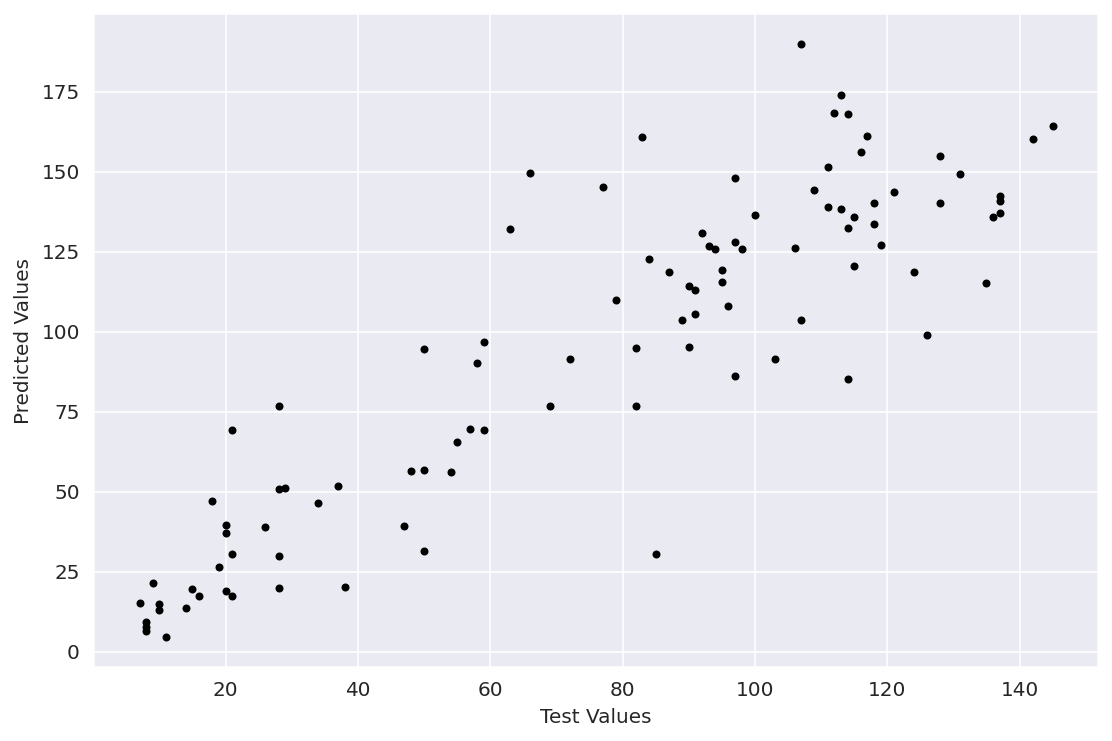

In [31]:
my_regression_results(random_search_xgb)

Model r-squared score from test data: 0.4965
Mean squared error on test data: 869.52
Root mean squared error on test data: 29.49


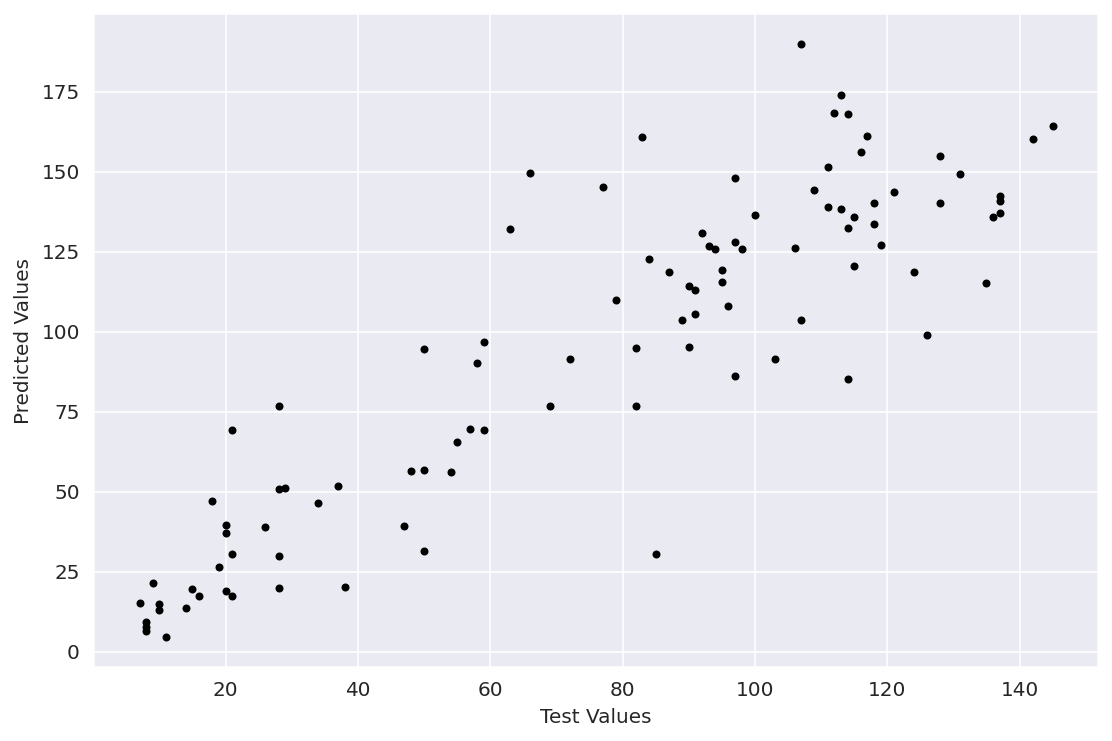

In [31]:
xgbr_model_optimal = xgb.XGBRegressor(
    learning_rate= 0.1,
    max_depth = 2,
    min_child_weight = 2,
    n_estimators= 115,
    reg_alpha= 1.1298003538030903,
    reg_lambda= 4.607840214514044,
    subsample= 0.7428130082444454,
    objective ='reg:squarederror')

xgbr_model_optimal.fit(X_train,y_train)

my_regression_results(xgbr_model_optimal)

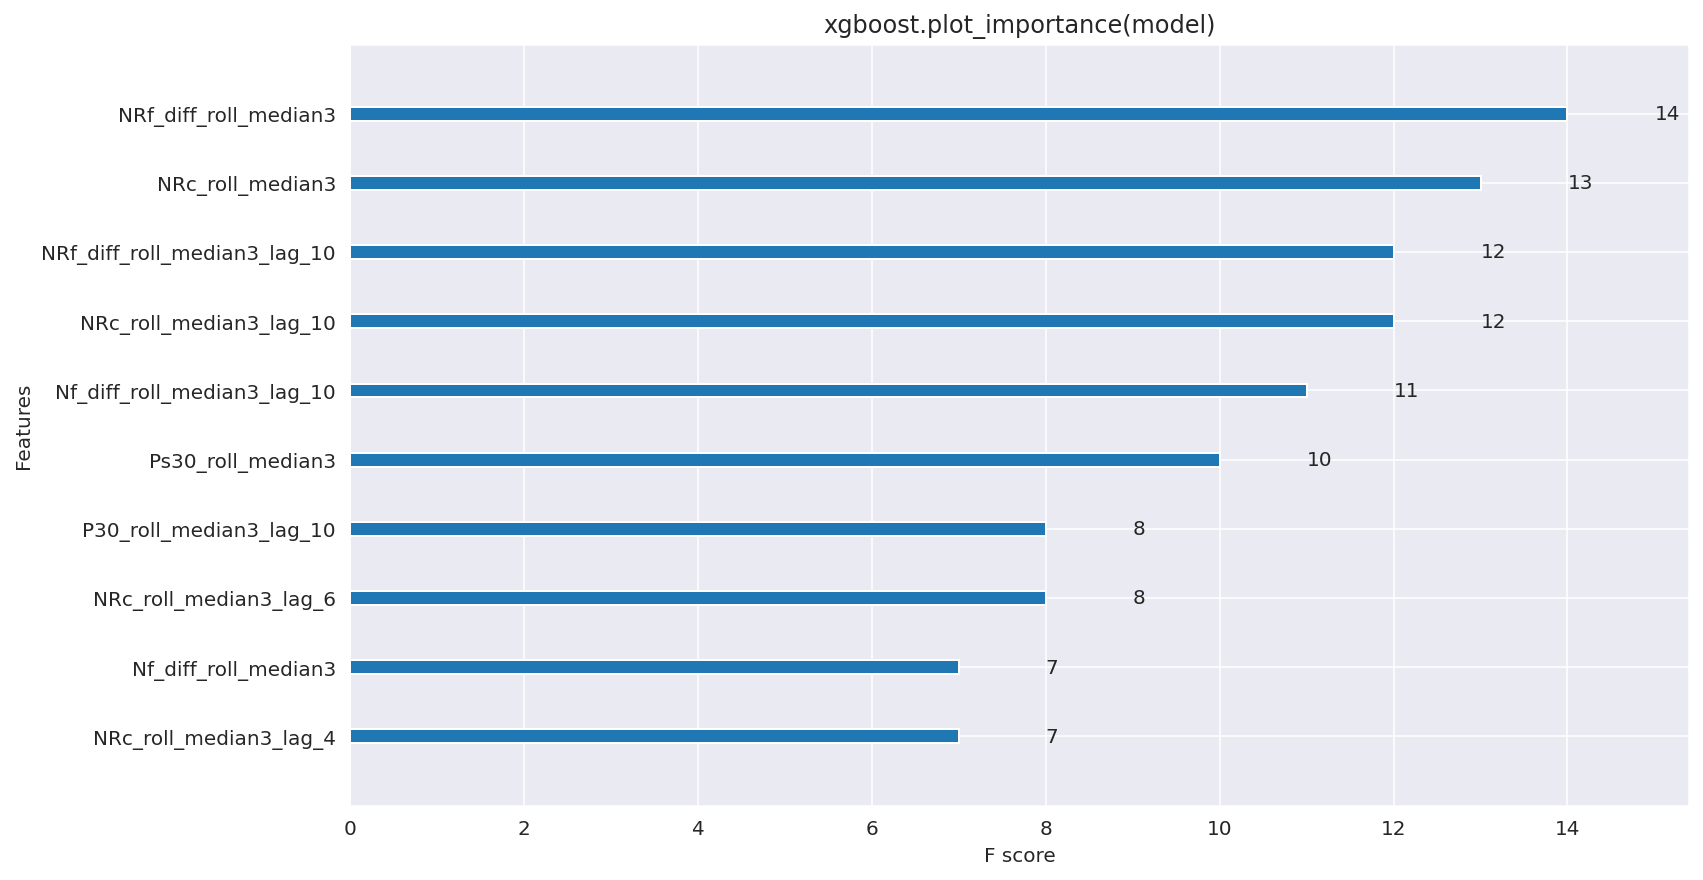

In [38]:
xgb.plot_importance(xgbr_model_optimal._Booster,max_num_features=10)
plt.title("xgboost.plot_importance(model)")
plt.savefig('model_feature_importance.png')
plt.show()


<AxesSubplot:>

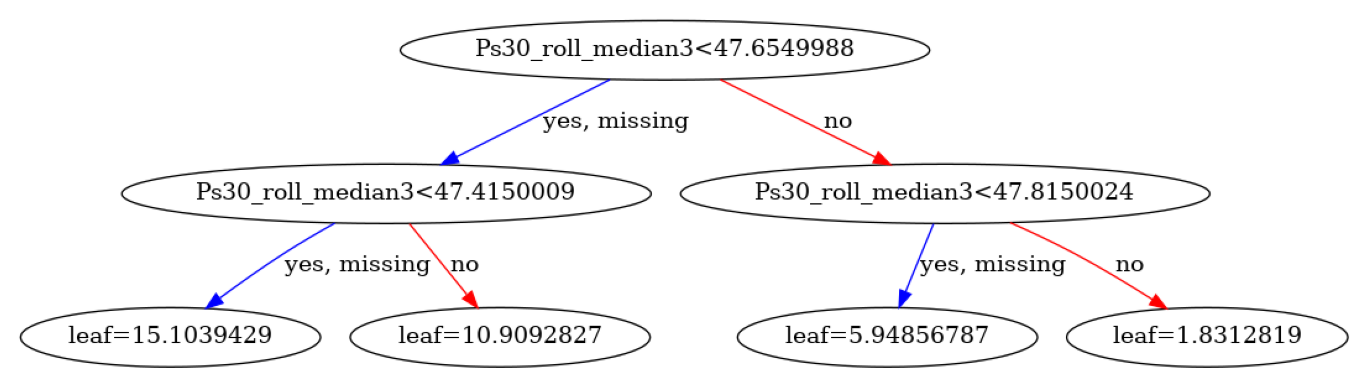

In [40]:
from xgboost import plot_tree

plot_tree(xgbr_model_optimal._Booster)

In [85]:
#Use grid search for our Xgboost regression model 
# define the grid
params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [2, 4, 6],
    "n_estimators": [10, 100,150],
    "subsample": [0.8, 1],
    "min_child_weight": [1, 3],
    "reg_lambda": [1, 3],
    "reg_alpha": [1, 3]
}

# setup the grid search
grid_search_xgb = GridSearchCV(xgbr_model,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [53]:
grid_search_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 3,
 'reg_lambda': 3,
 'subsample': 1}

Model r-squared score from test data: 0.0829
Mean squared error on test data: 1583.78
Root mean squared error on test data: 39.80


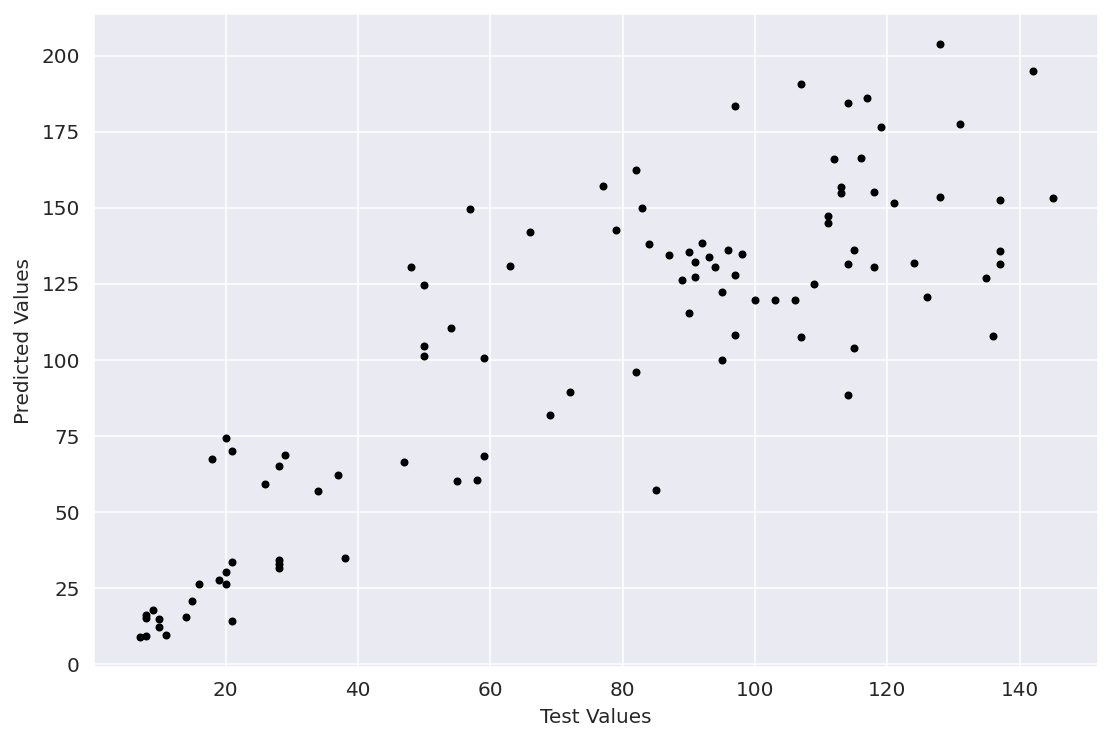

In [54]:
my_regression_results(grid_search_xgb)

#### Results following Tree Hyperparameter Tuning
Our most useful models have been from the tree-based models run on the dataset with the 10 lags and rolling aggregates. What would happen if we tuned the hyperparmeters? For a direct comparison to past approaches, we must stay consistent with the same X train and X test transformations we had last time we trained these models. 

In [32]:
d = {'Algorithm' : ['XGBoost Regression']
     ,'Data Transformations':['Random Search Hyperparameter Tuning']
     ,'Train R-squared':[round(random_search_xgb.score(X_train,y_train),2)]
     ,'Test R-squared':[round(my_short_regression_results(random_search_xgb)[0],2)]
     ,'Test Mean Squared Error':[round(my_short_regression_results(random_search_xgb)[1],2)]
     ,'Test Root Mean Squared Error':[round(my_short_regression_results(random_search_xgb)[2],2)]}
df = pd.DataFrame(data=d)
df

,Algorithm,Data Transformations,Train R-squared,Test R-squared,Test Mean Squared Error,Test Root Mean Squared Error
0,XGBoost Regression,Random Search Hyperparameter Tuning,0.68,0.5,869.52,29.49
